In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib notebook
import numpy as np
import pandas as pd
from scipy import interpolate
import scipy as sp
import pickle

import xmeos
from xmeos import models
from xmeos import datamod
from xmeos import eoslib

from collections import OrderedDict
CONSTS = models.CONSTS

In [2]:
mgpv_eos = eoslib.MgPv_Mosenfelder2009()

In [49]:
PT_fus_Stx09 = pd.read_csv('data/MgSiO3-pure-melt-curve-Stixrude2009.csv')

<IPython.core.display.Javascript object>


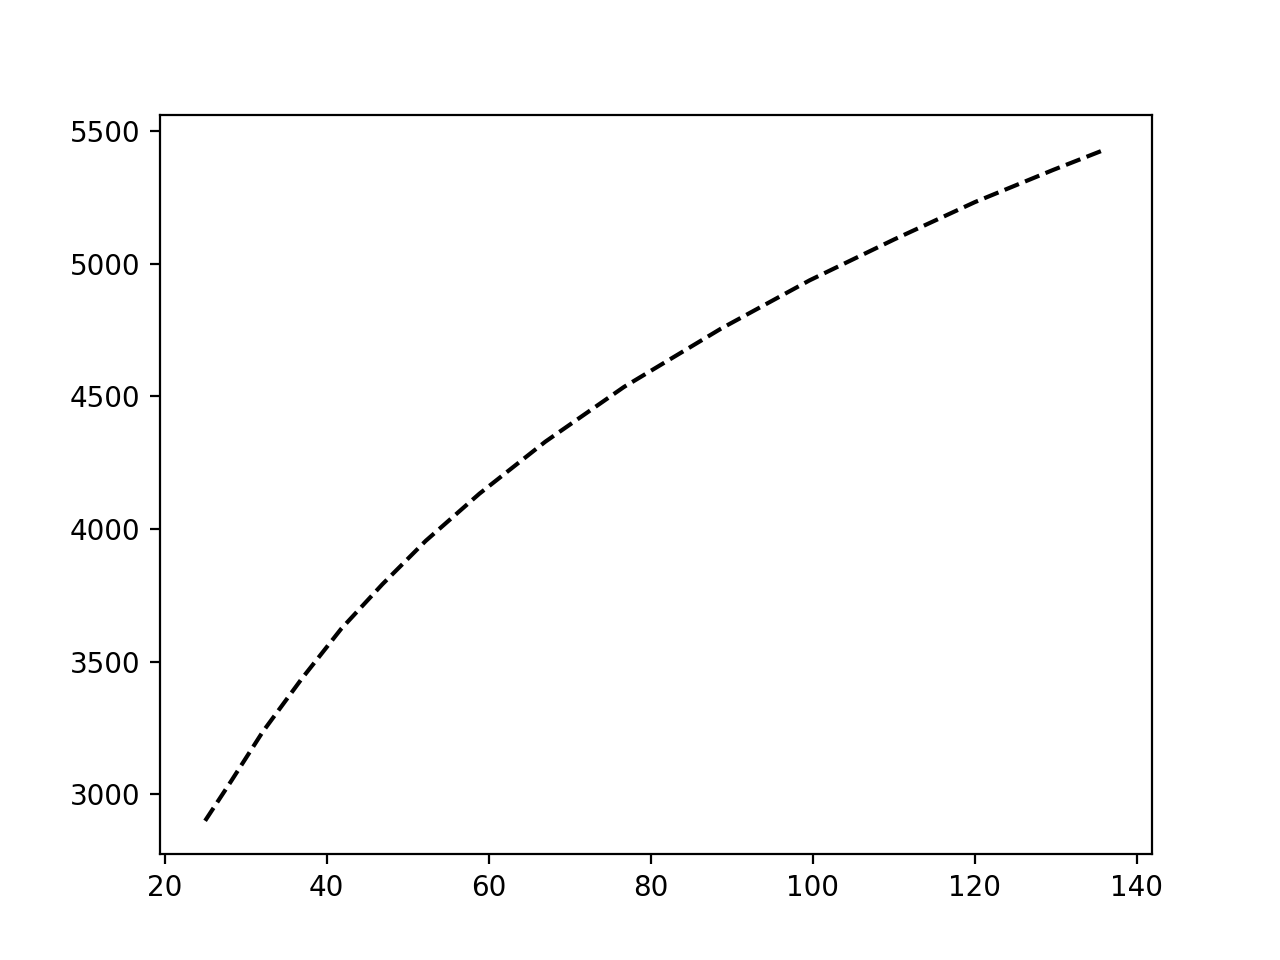

In [48]:
plt.figure()
plt.plot(PT_fus_Stx09['P'], PT_fus_Stx09['T'], 'k--')

In [3]:
analysis_file = 'data/analysis.pkl'
with open(analysis_file, 'rb') as f:
    analysis = pickle.load(f)

# NOTE: electronic contribution ignored, since plays little role near crystallization, and complicates debugging

In [4]:
datamodel = analysis['datamodel']
datamodel_dK09 = analysis['datamodel_dK09']
liq_eos = datamodel['eos_mod']
liq_eos_dK09 = datamodel_dK09['eos_mod']


# data = datamodel['data']
# data_dK09 = datamodel_dK09['data']
# props_Lange = analysis['props_Lange']
# props_Ghiorso = analysis['props_Ghiorso']

liq_eos.apply_electronic = False
liq_eos_dK09.apply_electronic = False

# liq_eos.apply_electronic = True
# liq_eos_dK09.apply_electronic = True

In [5]:
liq_thermal_eos = liq_eos
liq_compress_eos = liq_eos_dK09
sol_eos = mgpv_eos


In [7]:
def volume(P, T, eos_mod, Vinit=None, TOL=1e-3, bounds_error=True):


    def press_diff(V, P=P, T=T):
        return eos_mod.press(V, T) - P

    def press_diff_sqr(V, P=P, T=T):
        return (eos_mod.press(V, T) - P)**2

    def press_deriv(V, P=P, T=T):
        K = eos_mod.bulk_mod(V, T)
        dPdV = -K/V
        return dPdV

    
    if Vinit is None:
        V0, = eos_mod.get_param_values(param_names='V0')
        V_min0 = 0.8*V0
    else:
        V_min0 = Vinit
        
    V_min = sp.optimize.fmin(press_diff, V_min0, disp=False)

    #assert np.isscalar(Vinit), 'Vinit must be a scalar val.'
    # V = sp.optimize.fsolve(press_diff, Vinit, fprime=press_deriv)
    
    #V_min = sp.optimize.fmin(press_diff, Vinit, disp=False)

    if +press_diff(V_min) > +TOL:
        if bounds_error:
            raise ValueError(
                'The EOS is being sampled at an unphysical '
                'location! The target pressure is not accesible '
                'at this temperature.'
            )
        V = np.nan

    elif Vinit is None:
        output = sp.optimize.minimize(
            press_diff_sqr, [0.8*V_min], bounds=[(None, V_min)],
            options={'disp':False})
        V, = output.x

    else:
        #output = sp.optimize.minimize(
        #    press_diff_sqr, [Vinit], bounds=[(None, V_min)],
        #    options={'disp':False})
        #V, = output.x
        V = sp.optimize.fsolve(press_diff, Vinit, fprime=press_deriv)
    return V


In [8]:

    # Vsol_fus0 = volume(P_fus0, T_fus0, sol_eos)
    # S_sol0 = sol_eos.entropy(Vsol_fus0, T_fus0)
    # ,dS_fus=1.5,  P_fus0=25, T_fus0=2900
    # 
    # S_sol0 + dS_fus*CONSTS['kboltz'] +

In [25]:
class HybridEos():
    def __init__(self, compress_eos, thermal_eos, PTS_fus0=None):
        #, P_fus0=25, T_fus0=2900):
        self.compress_eos = compress_eos
        self.thermal_eos = thermal_eos
        
        self.init_fus_refstate(PTS_fus0)
        
    def init_fus_refstate(self, PTS_fus0):
        try:
            P_fus0, T_fus0, S_fus0 = PTS_fus0
            
            assert P_fus0 is not None
            assert T_fus0 is not None
            assert S_fus0 is not None
        except:
            assert False, (
                'PTS_fus0 must provide fusion ref state. '
                'PTS_fus0 is a tuple (P_fus0, T_fus0, S_fus0).'
            )
        
        V_fus0 = self.volume(P_fus0, T_fus0)
        
        self.P_fus0 = P_fus0
        self.T_fus0 = T_fus0
        self.S_fus0 = S_fus0
        self.V_fus0 = V_fus0
        return
        
        
    def press(self, V, T):
        return self.compress_eos.press(V, T)
    
    def volume(self, P, T, Vinit=9):
        return volume(P, T, self.compress_eos, Vinit=Vinit)
    
    def bulk_mod(self, V, T):
        return self.compress_eos.bulk_mod(V, T)
    
    def thermal_exp(self, V, T):
        return self.compress_eos.thermal_exp(V, T)
    
    
    def heat_capacity(self, V, T):
        return self.thermal_eos.heat_capacity(V, T)
    
    def dPdT(self, V, T):
        dPdT = (self.compress_eos.press(V, T+.5)
                - self.compress_eos.press(V, T-.5))
        return dPdT
    
    def gamma(self, V, T):
        dPdT = self.dPdT(V, T)
        Cv = self.heat_capacity(V, T)
        gamma = V*dPdT/Cv/CONSTS['PV_ratio']
        return gamma
    
    def dTdV_ad(self, V, T):
        gamma = self.gamma(V, T)
        dTdV = -gamma*T/V
        return dTdV
    
    
    def entropy(self, V, T):
        ind_sort = np.argsort(V)
        
        Vmin, Vmax = [V[ind_sort[0]], V[ind_sort[-1]]]
        
        if Vmin >= self.V_fus0:
            # all expand
            Vspan = [self.V_fus0, Vmax]
            
            pass
        elif Vmax <= self.V_fus0:
            # all contract
            Vspan = [self.V_fus0, Vmin]
            pass
        else:
            # mixed expand and contract
            Vspan_expand = [self.V_fus0, Vmax]
            Vspan_contract = [self.V_fus0, Vmin]
        
        
        
        
        
        # V_path = np.hstack((self.V_fus0, V))
        # 
        # output = sp.integrate.solve_ivp(self.dTdV_ad, Vspan, self.T_fus0, 
        #                                 t_eval=V, vectorized=True)
        # dTdV_ad, T_fus0, V_path , 
        # args=(liq_compress_eos, liq_thermal_eos))[1:,0]
        # 
        # 
        # dV = V[1]-V[0]
        # Vspan = [0, V[-1]]
        # 
        # output = sp.integrate.solve_ivp(self.dTdV_ad, Vspan, Tinit, 
        #                                 t_eval=V, vectorized=True)
        # 
        # 
        # dS = (liq_thermal_eos.entropy(V, T) 
        #       -liq_thermal_eos.entropy(V, Tad))
        
        S = self.S_fus0 + dS
        return S
    def internal_energy():
        pass
    
    def adiabatic_path(self, Tinit, P_path):
        Pinit = P_path[0]
        Vinit = volume(Pinit, Tinit, self.compress_eos, Vinit=9)
        
        
        V = np.linspace(Vinit, Vinit*.4, 1001)
        Vspan = [Vinit, V[-1]]
        
        output = sp.integrate.solve_ivp(self.dTdV_ad, Vspan, Tinit, 
                                        t_eval=V, vectorized=True)
        
        
        Tad = output['y']
        # Pad = liq_compress_eos.press(V, Tad)
        
        return V, Tad
    
    


    
    
        
        
    

In [26]:
P_fus0 = 25
T_fus0 = 2900
dS_fus=1.5


Vsol_fus0 = volume(P_fus0, T_fus0, sol_eos)
S_sol0 = sol_eos.entropy(Vsol_fus0, T_fus0)
S_fus0 = S_sol0 + dS_fus*CONSTS['kboltz']

hybrid_eos = HybridEos(liq_compress_eos, liq_thermal_eos, 
                       PTS_fus0=(P_fus0, T_fus0, S_fus0))

In [38]:
T0 = 2500

def eval_props(P, T):
    V = hybrid_eos.volume(P, T)
    results = {}
    results['V'] = V
    results['P'] = hybrid_eos.press(V, T)
    
    results['K'] = hybrid_eos.bulk_mod(V, T)
    results['alpha'] = hybrid_eos.thermal_exp(V, T)
    results['gamma'] = hybrid_eos.gamma(V, T)
    results['Cv'] = hybrid_eos.heat_capacity(V, T)/CONSTS['kboltz']
    results['dPdT'] = hybrid_eos.dPdT(V, T)
    return results


# 
# P, T = 100, 5000
# print('P =',P,', T =',T)
# eval_props(P, T)

In [39]:
P, T = 0, 2000
print('P =',P,', T =',T)
eval_props(P, T)

P = 0 , T = 2000


{'Cv': array([4.18000125]),
 'K': array([16.54021148]),
 'P': array([8.8817842e-16]),
 'V': array([12.94309967]),
 'alpha': array([0.00012641]),
 'dPdT': array([0.00209082]),
 'gamma': array([0.46891582])}

In [40]:
P, T = 30, 2000
print('P =',P,', T =',T)
eval_props(P, T)

P = 30 , T = 2000


{'Cv': array([4.19820933]),
 'K': array([164.55912211]),
 'P': array([30.]),
 'V': array([8.55946146]),
 'alpha': array([2.53813982e-05]),
 'dPdT': array([0.00417674]),
 'gamma': array([0.61678908])}

In [42]:
P, T = 90, 2000
print('P =',P,', T =',T)
eval_props(P, T)

P = 90 , T = 2000


{'Cv': array([4.50263847]),
 'K': array([398.60234117]),
 'P': array([90.]),
 'V': array([6.83498357]),
 'alpha': array([1.94872376e-05]),
 'dPdT': array([0.00776766]),
 'gamma': array([0.8540383])}

In [43]:
P, T = 90, 5000
print('P =',P,', T =',T)
eval_props(P, T)


P = 90 , T = 5000


{'Cv': array([3.53216403]),
 'K': array([363.79203123]),
 'P': array([90.]),
 'V': array([7.19976933]),
 'alpha': array([1.65771866e-05]),
 'dPdT': array([0.00603065]),
 'gamma': array([0.89034546])}

In [29]:
P_path = np.linspace(10,100,101)
print(T0)
Vad, Tad = hybrid_eos.adiabatic_path(T0, P_path)

2500


ValueError: `y0` must be 1-dimensional.

In [ ]:
results['S0'] = hybrid_eos.entropy(V0, T0)/CONSTS['kboltz']

<IPython.core.display.Javascript object>


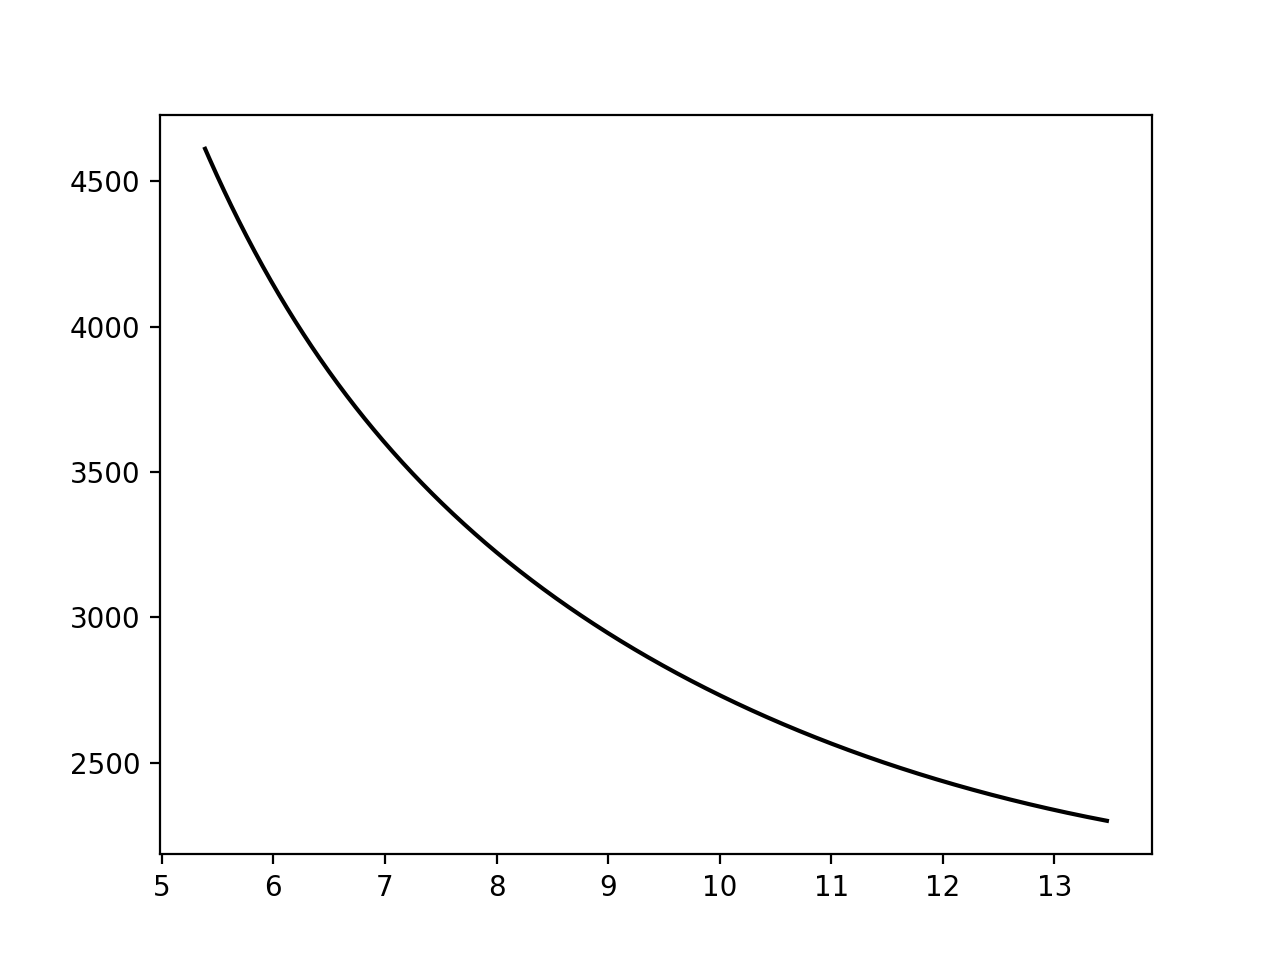

<IPython.core.display.Javascript object>


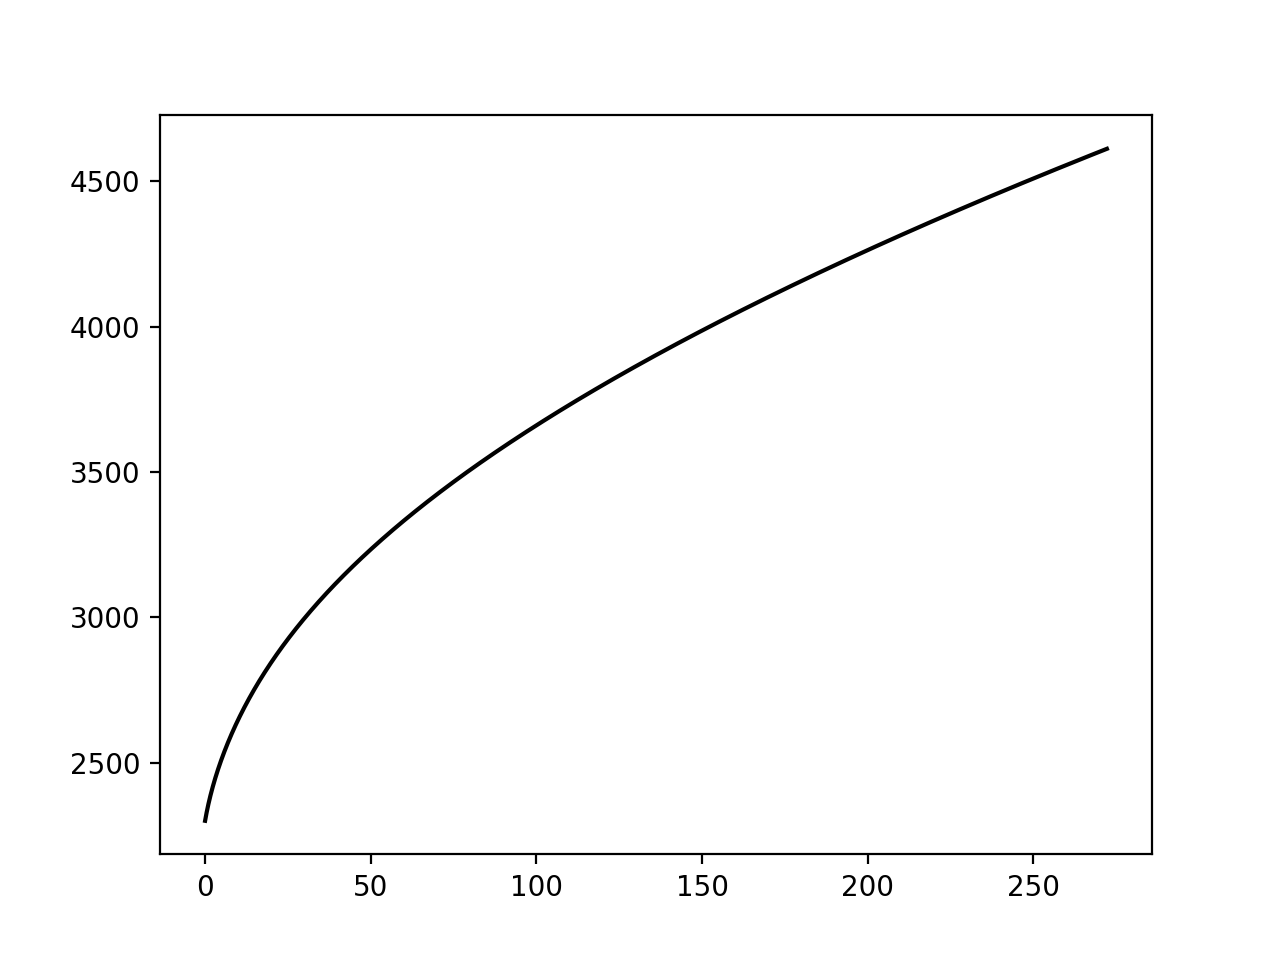

<IPython.core.display.Javascript object>


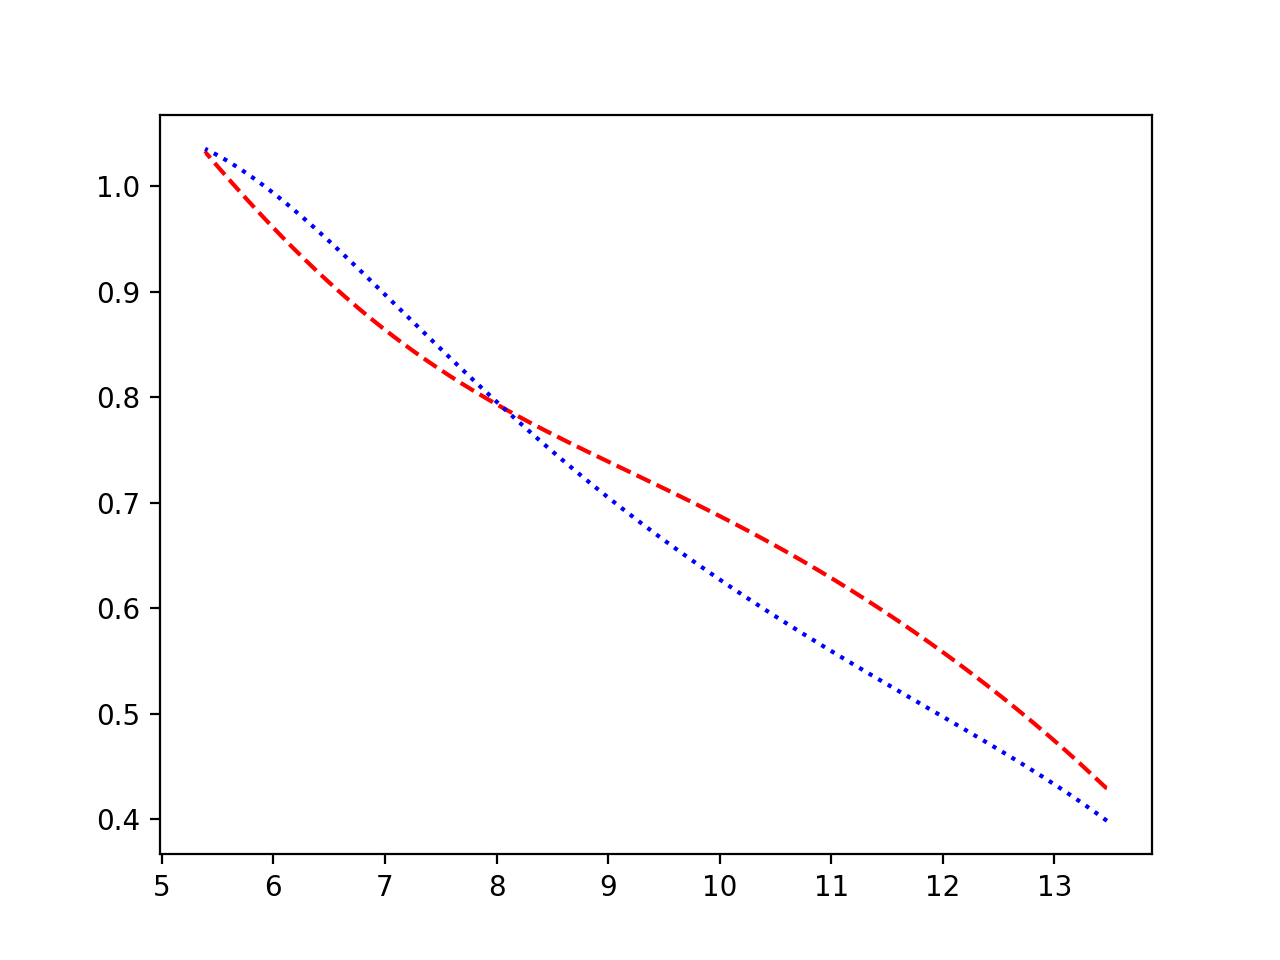

In [8]:
Pinit = 0
Tinit = 2300


Vinit = volume(Pinit,Tinit,liq_compress_eos, Vinit=9)
V = np.linspace(Vinit, Vinit*.4, 1001)
dV = V[1]-V[0]

Tad = sp.integrate.odeint(dTdV_ad, Tinit, V, args=(liq_compress_eos, liq_thermal_eos))[:,0]
Pad = liq_compress_eos.press(V, Tad)



plt.figure()
plt.plot(V, Tad, 'k-')

plt.figure()
plt.plot(Pad, Tad, 'k-')

plt.figure()

dTdV = np.gradient(Tad, dV)
plt.plot(V, -V/Tad*dTdV, 'r--', V , liq_compress_eos.gamma(V, Tad), 'b:')

<IPython.core.display.Javascript object>


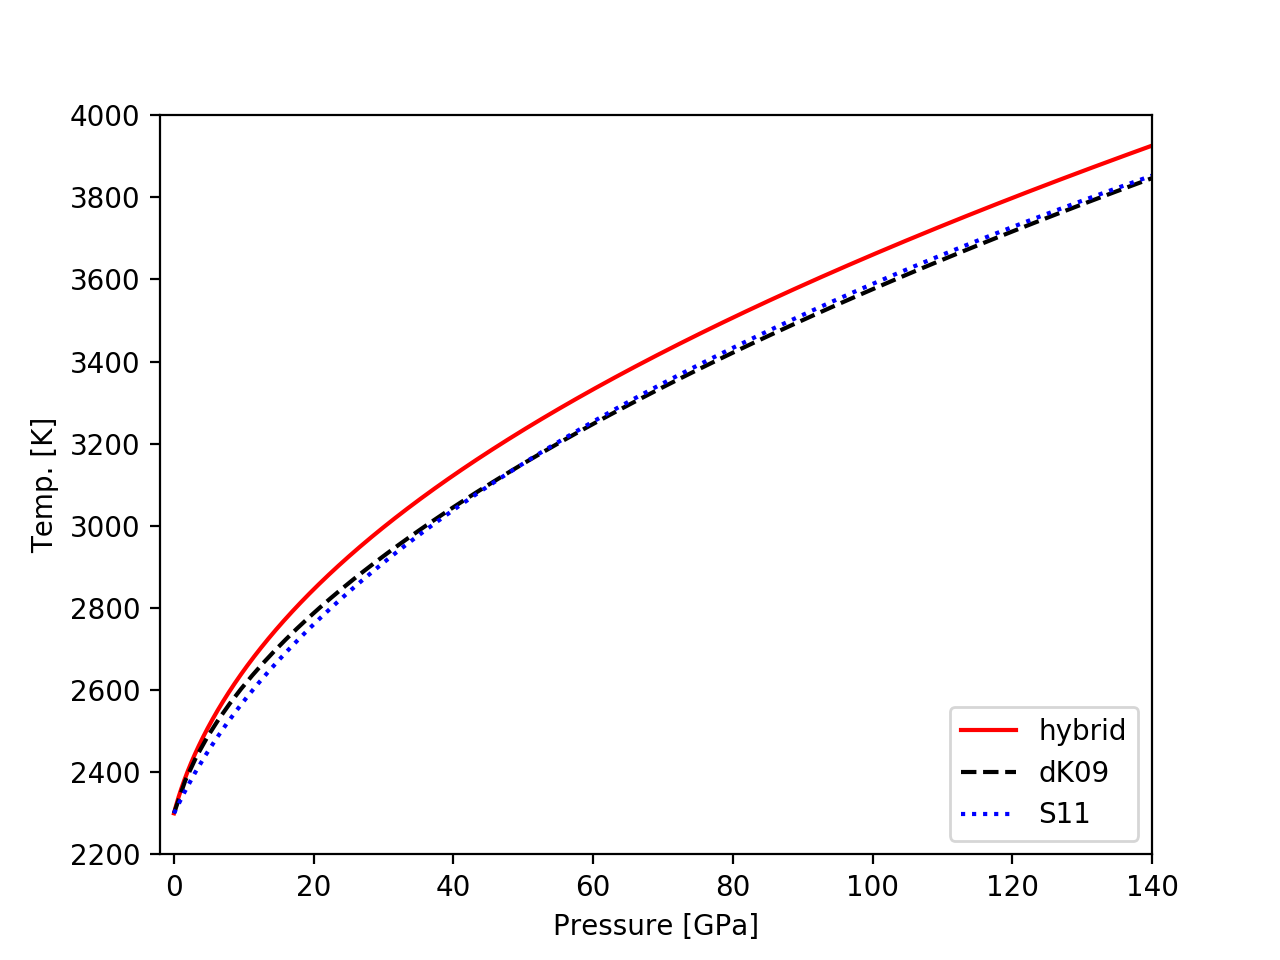

In [9]:
Vad_dK09, Tad_dK09 = liq_compress_eos.adiabatic_path(Tinit, np.linspace(0,160,101))
Pad_dK09 = liq_compress_eos.press(Vad_dK09,Tad_dK09)
Sad_dK09 = liq_compress_eos.entropy(Vad_dK09, Tad_dK09)

Vad_S11, Tad_S11 = liq_thermal_eos.adiabatic_path(Tinit, np.linspace(0,150,101))
Pad_S11 = liq_thermal_eos.press(Vad_S11,Tad_S11)
Sad_S11 = liq_thermal_eos.entropy(Vad_S11, Tad_S11)

plt.figure()
plt.plot(Pad,Tad, 'r-', Pad_dK09, Tad_dK09, 'k--', Pad_S11, Tad_S11, 'b:')
plt.legend(['hybrid','dK09','S11'], loc='lower right')
plt.xlabel('Pressure [GPa]')
plt.ylabel('Temp. [K]')
plt.xlim(-2,140)
plt.ylim(2200,4000)

plt.savefig('figs/hybrid-ref-adiabat.png', dpi=450)
# plt.figure()
# plt.plot(Pad_dK09, Sad_dK09-np.mean(Sad_dK09) , 'k--', 
#          Pad_S11, Sad_S11 - np.mean(Sad_S11), 'b:')

<IPython.core.display.Javascript object>


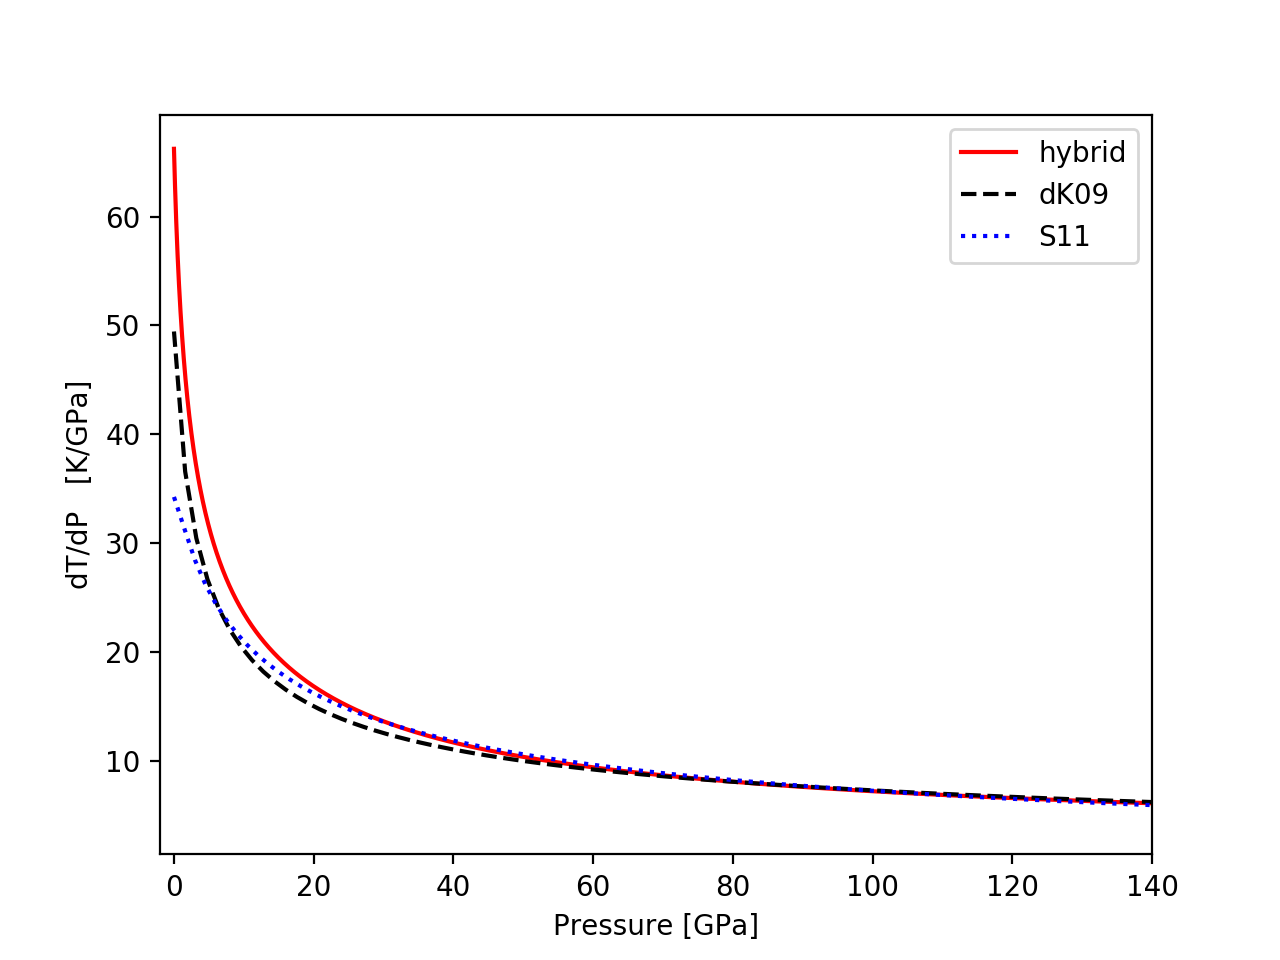

In [10]:

plt.figure()
plt.plot(Pad[:-1],(Tad[1:]-Tad[:-1])/(Pad[1:]-Pad[:-1]), 'r-',
         Pad_dK09[:-1], (Tad_dK09[1:]-Tad_dK09[:-1])/(Pad_dK09[1:]-Pad_dK09[:-1]), 'k--',
         Pad_S11[:-1], (Tad_S11[1:]-Tad_S11[:-1])/(Pad_S11[1:]-Pad_S11[:-1]), 'b:')
plt.legend(['hybrid','dK09','S11'], loc='upper right')
plt.xlabel('Pressure [GPa]')
plt.ylabel('dT/dP   [K/GPa]')
plt.xlim(-2,140)

plt.savefig('figs/hybrid-ref-adiabat-slope.png', dpi=450)


## Adjust liquid entropy to be realistic at reference point on melting curve

In [11]:
def adjust_melting_entropy(P_fus0, T_fus0, sol_eos, liq_eos, dS_fus=1.5, Vliq_init=9.1):
    Vliq_fus0 = volume(P_fus0, T_fus0, liq_eos, Vinit=9)
    Vsol_fus0 = volume(P_fus0, T_fus0, sol_eos)
    
    # print(Vliq_fus0)
    # print(Vsol_fus0)

    # print(liq_eos.press(Vliq_fus0, T_fus0))
    # print(sol_eos.press(Vsol_fus0, T_fus0))

    liq_eos.set_param_values(0, param_names='S0')

    Sliq_fus0_init = liq_eos.entropy(Vliq_fus0, T_fus0)
    Ssol_fus0 = sol_eos.entropy(Vsol_fus0, T_fus0)

    S0 = Ssol_fus0 + dS_fus*CONSTS['kboltz'] - Sliq_fus0_init
    liq_eos.set_param_values(S0, param_names='S0')
    
    TOL = 1e-5
    S_error = (liq_eos.entropy(Vliq_fus0, T_fus0)
               - sol_eos.entropy(Vsol_fus0, T_fus0))/CONSTS['kboltz']-dS_fus
    assert np.abs(S_error)<TOL, (
        'fusion entropy does not match expectation... something wrong here.'
    )
    return S0




In [100]:
P_fus0 = 25
T_fus0 = 2900

adjust_melting_entropy(P_fus0, T_fus0, mgpv_eos, liq_eos, dS_fus=1.5)
adjust_melting_entropy(P_fus0, T_fus0, mgpv_eos, liq_eos_dK09, dS_fus=1.5)

print('S0( S11) = ', liq_eos.get_param_values(param_names='S0')[0])
print('S0(dK09) = ', liq_eos_dK09.get_param_values(param_names='S0')[0])

S0( S11) =  0.0005615097508127171
S0(dK09) =  0.0005815462358227297


In [201]:
def dK09_funs():
    liq_funs = {}
    # liq_funs['entropy'] = lambda V, T: liq_eos.entropy(V, T)[0]
    liq_funs['entropy']  = liq_eos.entropy
    liq_funs['bulk_mod'] = liq_eos.bulk_mod
    liq_funs['alpha']    = liq_eos.thermal_exp
    liq_funs['press']    = liq_eos.press
    liq_funs['gibbs']    = lambda V, T: (
        liq_eos.internal_energy(V, T) 
        -T*liq_eos.entropy(V, T) 
        +liq_eos.press(V, T)*V/CONSTS['PV_ratio'])
    liq_funs['volume']   = lambda P, T: volume(P, T, liq_eos)
    
    sol_funs = {}
    sol_funs['entropy']  = mgpv_eos.entropy
    sol_funs['bulk_mod'] = mgpv_eos.bulk_mod
    sol_funs['alpha']    = mgpv_eos.thermal_exp
    sol_funs['press']    = mgpv_eos.press
    sol_funs['gibbs']    = lambda V, T: (
        mgpv_eos.internal_energy(V, T) 
        -T*mgpv_eos.entropy(V, T) 
        +mgpv_eos.press(V, T)*V/CONSTS['PV_ratio'])
    
    sol_funs['volume']   = lambda P, T: volume(P, T, mgpv_eos)
    
    return liq_funs, sol_funs

def S11_funs():
    return args

def hybrid_funs():
    return args

In [202]:
liq_funs, sol_funs = dK09_funs()
print(liq_funs['entropy'](9, 2500))
print(sol_funs['entropy'](9, 2500))

print(liq_funs['bulk_mod'](9, 2500))
print(sol_funs['bulk_mod'](9, 2500))

print(liq_funs['alpha'](9, 2500))
print(sol_funs['alpha'](9, 2500))

print(liq_funs['volume'](9, 2500))
print(sol_funs['volume'](9, 2500))


print(liq_funs['gibbs'](9, 2500))
print(sol_funs['gibbs'](9, 2500))

[0.00043996]
[0.00037552]
[121.43926614]
[138.89486596]
[4.20487574e-05]
[5.77551335e-05]
9.82586222279627
8.369164458565677
[-19.23142336]
[-0.69304364]


In [203]:
def melt_bound(P, T_Vl_Vs, liq_funs, sol_funs):
    T, Vl, Vs = T_Vl_Vs[:]
    
    Sl = liq_funs['entropy'](Vl, T)
    Ss = sol_funs['entropy'](Vs, T)
    
    dV = Vl-Vs
    dS = Sl-Ss
    
    KT_l = liq_funs['bulk_mod'](Vl, T)
    KT_s = sol_funs['bulk_mod'](Vs, T)
    
    alpha_l = liq_funs['alpha'](Vl, T)
    alpha_s = sol_funs['alpha'](Vs, T)
     
    dTdP = dV/dS/CONSTS['PV_ratio']
    dVldP = -Vl/KT_l + alpha_l*Vl*dTdP
    dVsdP = -Vs/KT_s + alpha_s*Vs*dTdP
    
    derivs = [dTdP, dVldP, dVsdP]
    return derivs





# solve_ivp(fun=lambda t, y: fun(t, y, *dK09_funs()), ...)

In [204]:
P0 = 25
T0 = 2900
liq_dK09, sol_dK09 = dK09_funs()
V0l = liq_dK09['volume'](P0, T0)
V0s = sol_dK09['volume'](P0, T0)
dG0 = liq_dK09['gibbs'](V0l, T0)-sol_dK09['gibbs'](V0s, T0)
P_mod = np.linspace(P0, 136, 101)

output = sp.integrate.solve_ivp(lambda t, y: melt_bound(t, y, *(liq_dK09, sol_dK09)),
                       [P0,136], [T0, V0l, V0s], t_eval=P_mod, vectorized=True)
T_mod = output['y'][0]
Vl_mod = output['y'][1]
Vs_mod = output['y'][2]



In [168]:
P0 = 25
T0 = 2900
liq_dK09, sol_dK09 = dK09_funs()
V0l = liq_dK09['volume'](P0, T0)
V0s = sol_dK09['volume'](P0, T0)
P_mod = np.linspace(P0, 12.5, 101)

output = sp.integrate.solve_ivp(lambda t, y: melt_bound(t, y, *(liq_dK09, sol_dK09)),
                                [P0,12.5], [T0, V0l, V0s], t_eval=P_mod, vectorized=True)
T_mod = output['y'][0]
Vl_mod = output['y'][1]
Vs_mod = output['y'][2]

/Users/aswolf/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


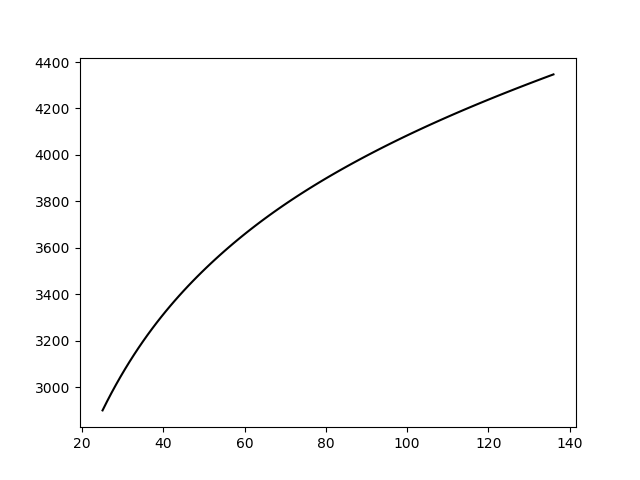

In [205]:
plt.figure()
plt.plot(P_mod, T_mod, 'k-')


<IPython.core.display.Javascript object>


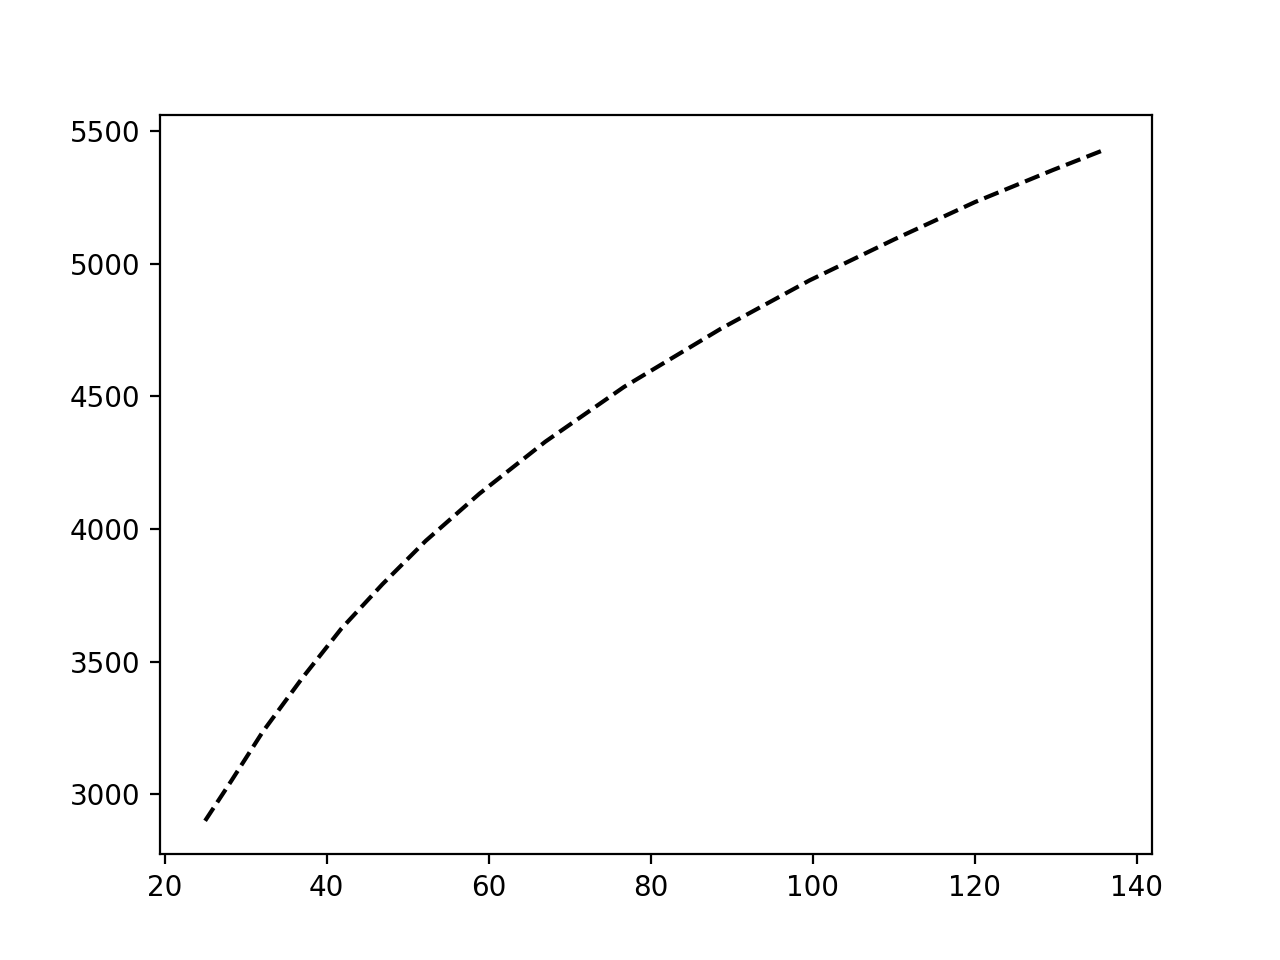

In [50]:
plt.figure()
plt.plot(PT_fus_Stx09['P'], PT_fus_Stx09['T'], 'k--')

/Users/aswolf/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


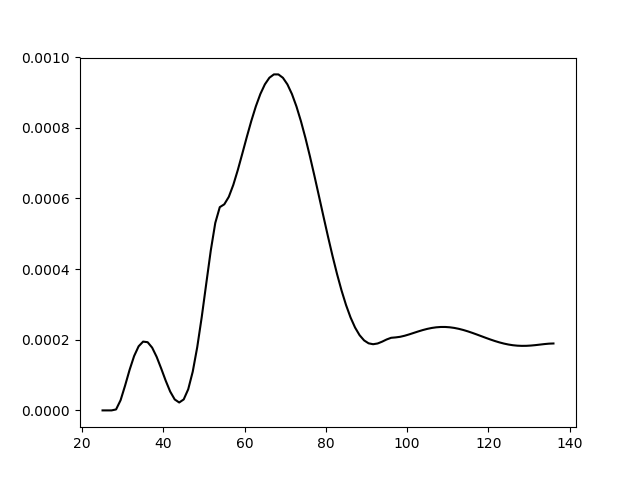

<IPython.core.display.Javascript object>


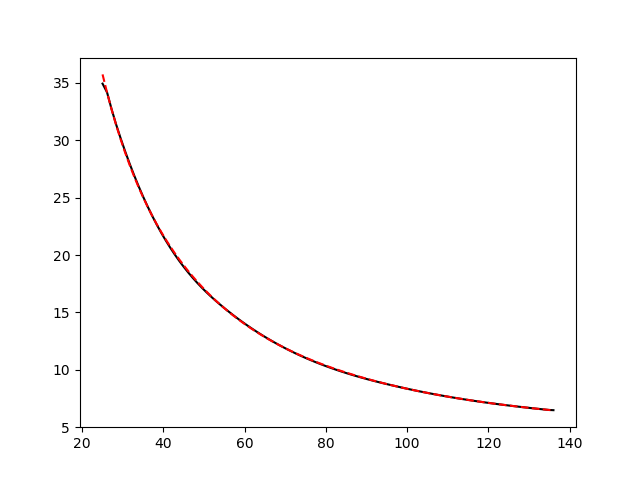

<IPython.core.display.Javascript object>


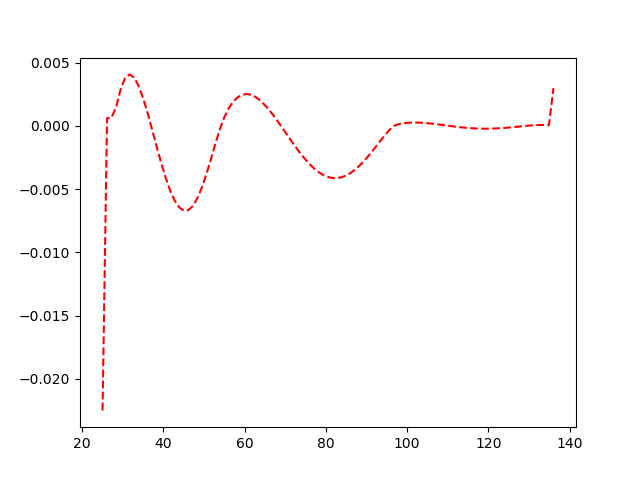

<IPython.core.display.Javascript object>


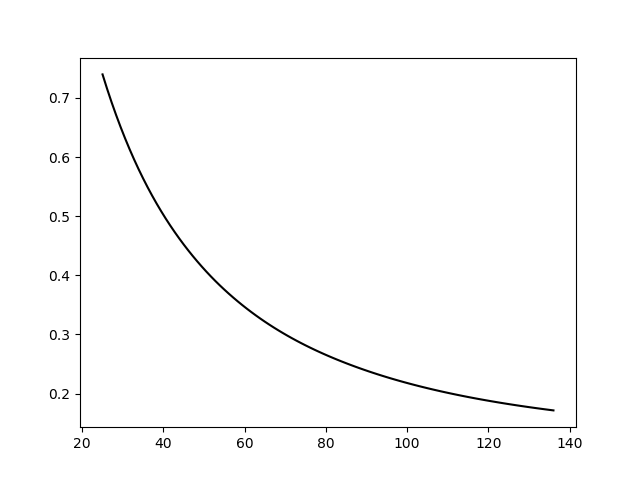

<IPython.core.display.Javascript object>


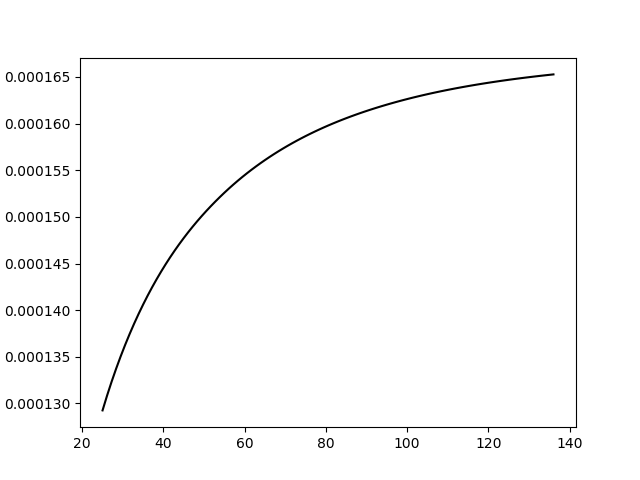

In [206]:
dP = P_mod[1]-P_mod[0]
dTdP_num = np.gradient(T_mod, dP)
dV_mod = Vl_mod-Vs_mod

Sl_mod = liq_dK09['entropy'](Vl_mod, T_mod)
Ss_mod = sol_dK09['entropy'](Vs_mod, T_mod)
dS_mod = Sl_mod-Ss_mod

dTdP_man = dV_mod/dS_mod/CONSTS['PV_ratio']

dG_mod = liq_dK09['gibbs'](Vl_mod, T_mod)-sol_dK09['gibbs'](Vs_mod, T_mod)

plt.figure()
plt.plot(P_mod, (liq_dK09['gibbs'](Vl_mod, T_mod)
                 -sol_dK09['gibbs'](Vs_mod, T_mod)-dG0), 'k-')

plt.figure()
plt.plot(P_mod, dTdP_num, 'k-', P_mod, dTdP_man, 'r--')

plt.figure()
plt.plot(P_mod, dTdP_num/dTdP_man - 1, 'r--')

plt.figure()
plt.plot(P_mod, dV_mod, 'k-')
plt.figure()
plt.plot(P_mod, dS_mod, 'k-')

<IPython.core.display.Javascript object>


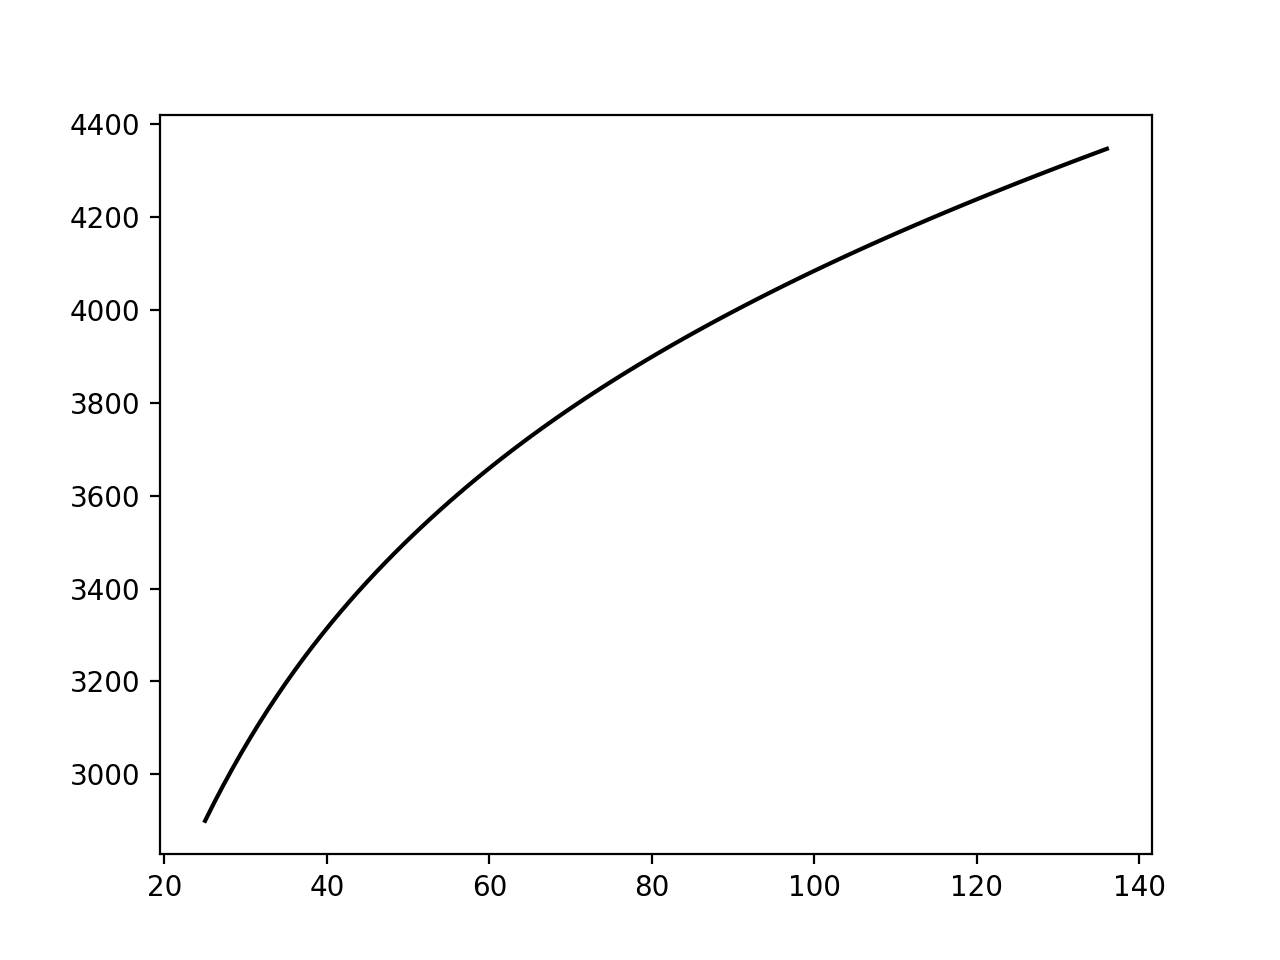

<IPython.core.display.Javascript object>


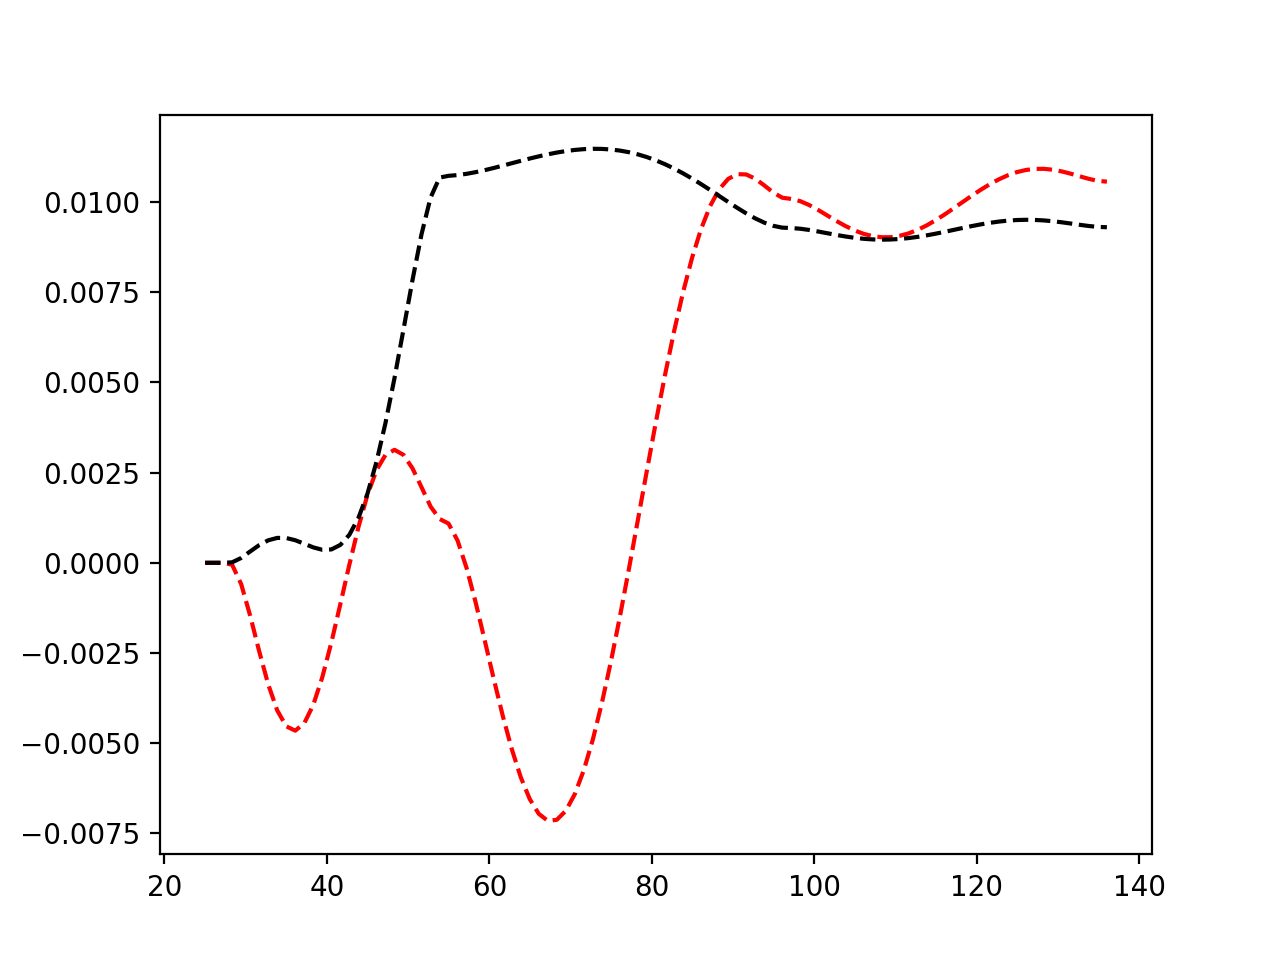

In [171]:

plt.figure()
# 

plt.plot(P_mod, P_mod - liq_dK09['press'](Vl_mod, T_mod), 'r--')
plt.plot(P_mod, P_mod - sol_dK09['press'](Vs_mod, T_mod), 'k--')


In [71]:
def trace_phase_bound(Pinit, Tinit, Plim, phase1_eos, phase2_eos, 
                      Vinit1=None, Vinit2=None, N=100, full_output=False):
    
    Pbound = np.linspace(Pinit, Plim, N)
    Tbound = np.zeros(N)
    Tbound[0] = Tinit
    
    V1_bound = np.zeros(N)
    V2_bound = np.zeros(N)
    S1_bound = np.zeros(N)
    S2_bound = np.zeros(N)
    dV_bound = np.zeros(N)
    dS_bound = np.zeros(N)
    
    dP = Pbound[1]-Pbound[0]
    
    Vphase1_init = volume(Pinit, Tinit, phase1_eos, Vinit=Vinit1)
    Vphase2_init = volume(Pinit, Tinit, phase2_eos, Vinit=Vinit2)

    for ind, (P, T) in enumerate(zip(Pbound[:-1], Tbound[:-1])):
        Vphase1 = volume(P, T, phase1_eos, Vinit=Vphase1_init)
        Vphase2 = volume(P, T, phase2_eos, Vinit=Vphase2_init)
        Sphase1 = phase1_eos.entropy(Vphase1, T)[0]
        Sphase2 = phase2_eos.entropy(Vphase2, T)[0]
        
        dV = Vphase2-Vphase1
        dS = Sphase2 - Sphase1
        
        dV_bound[ind] = dV
        dS_bound[ind] = dS
        V1_bound[ind] = Vphase1
        V2_bound[ind] = Vphase2
        S1_bound[ind] = Sphase1
        S2_bound[ind] = Sphase2
        
        dTdP = dV/dS/CONSTS['PV_ratio']
        dT = dTdP*dP
        
        Pbound[ind+1] = P+dP
        Tbound[ind+1] = T+dT
        
        Vphase1_init = Vphase1
        Vphase2_init = Vphase2

    if full_output:
        output = {}
        output['V1'] = V1_bound
        output['V2'] = V2_bound
        output['S1'] = S1_bound
        output['S2'] = S2_bound
        output['dV'] = dV_bound
        output['dS'] = dS_bound
        return Pbound, Tbound, output
    else:
        return Pbound, Tbound
    return Pbound, Tbound

In [52]:
def trace_hybrid_phase_bound(Pinit, Tinit, Plim, 
                             sol_eos, liq_thermal_eos, liq_compress_eos,
                             Vinit_sol=None, N=100, full_output=False):
    
    Pbound = np.linspace(Pinit, Plim, N)
    Tbound = np.zeros(N)
    Tbound[0] = Tinit
    
    dP = Pbound[1]-Pbound[0]
    
    Vsol_bound = np.zeros(N)
    Vliq_bound = np.zeros(N)
    dV_bound = np.zeros(N)
    dS_bound = np.zeros(N)
    
    Vsol_init = volume(Pinit, Tinit, sol_eos, Vinit=Vinit_sol)
    Vliq_init = hybrid_volume(Pinit, Tinit)

    for ind, (P, T) in enumerate(zip(Pbound[:-1], Tbound[:-1])):
        Vsol = volume(P, T, sol_eos, Vinit=Vsol_init)
        Vliq = hybrid_volume(P, T, Vinit=Vliq_init)
        
        Vsol_bound[ind] = Vsol
        Vliq_bound[ind] = Vliq
        
        
        dV = Vliq-Vsol
        dS = (hybrid_entropy(Vliq, T) 
              - sol_eos.entropy(Vsol, T))[0]
        
        dV_bound[ind] = dV
        dS_bound[ind] = dS
        
        dTdP = dV/dS/CONSTS['PV_ratio']
        dT = dTdP*dP
        
        Pbound[ind+1] = P+dP
        Tbound[ind+1] = T+dT
        
        Vsol_init = Vsol
        Vliq_init = Vliq
        

    if full_output:
        output = {}
        output['dV'] = dV_bound
        output['dS'] = dS_bound
        output['Vliq'] = Vliq_bound
        output['Vsol'] = Vsol_bound
        return Pbound, Tbound, output
    else:
        return Pbound, Tbound

In [91]:
P_fus_LM, T_fus_LM =  trace_phase_bound(P_fus0, T_fus0, 136, mgpv_eos, liq_eos)
P_fus_dK09_LM, T_fus_dK09_LM =  trace_phase_bound(
    P_fus0, T_fus0, 136, mgpv_eos, liq_eos_dK09, Vinit2=9)
P_fus_hybrid_LM, T_fus_hybrid_LM =  trace_hybrid_phase_bound(
    P_fus0, T_fus0, 136, mgpv_eos, liq_eos, liq_eos_dK09)


In [94]:
P_fus_UM, T_fus_UM =  trace_phase_bound(P_fus0, T_fus0, 12.5, mgpv_eos, liq_eos)
P_fus_dK09_UM, T_fus_dK09_UM =  trace_phase_bound(
    P_fus0, T_fus0, 12.5, mgpv_eos, liq_eos_dK09, Vinit2=9)
P_fus_hybrid_UM, T_fus_hybrid_UM =  trace_hybrid_phase_bound(
    P_fus0, T_fus0, 12.5, mgpv_eos, liq_eos, liq_eos_dK09)


In [172]:
P_fus, T_fus =  trace_phase_bound(P_fus0, T_fus0, 136, mgpv_eos, liq_eos)
P_fus_dK09, T_fus_dK09, output_dK09 =  trace_phase_bound(P_fus0, T_fus0, 136, 
                                            mgpv_eos, liq_eos_dK09, Vinit2=9, 
                                                         full_output=True)


In [35]:
P_fus_hybrid0, T_fus_hybrid0 =  trace_inconsistent_hybrid_phase_bound(
    P_fus0, T_fus0, 136, mgpv_eos, liq_eos, liq_eos_dK09, Vinit_liq_compress=9)


In [36]:
P_fus_hybrid, T_fus_hybrid, output_hybrid =  trace_hybrid_phase_bound(
    P_fus0, T_fus0, 136, mgpv_eos, liq_eos, liq_eos_dK09, full_output=True)


In [92]:
T_fus0

2900

In [88]:
P_fus_dK09, T_fus_dK09, output_dK09 =  trace_phase_bound(P_fus0, T_fus0, 12.5, 
                                            mgpv_eos, liq_eos_dK09, Vinit2=9, 
                                                         full_output=True)
P_fus_hybrid, T_fus_hybrid, output_hybrid =  trace_hybrid_phase_bound(
    P_fus0, T_fus0, 12.5, mgpv_eos, liq_eos, liq_eos_dK09, full_output=True)


In [82]:
T0=1400
P_fus_dK09, T_fus_dK09, output_dK09 =  trace_phase_bound(10, T0, 25, 
                                            mgpv_eos, liq_eos_dK09, Vinit2=9, 
                                                         full_output=True)
P_fus_hybrid, T_fus_hybrid, output_hybrid =  trace_hybrid_phase_bound(
    10, T0, 25, mgpv_eos, liq_eos, liq_eos_dK09, full_output=True)


<IPython.core.display.Javascript object>


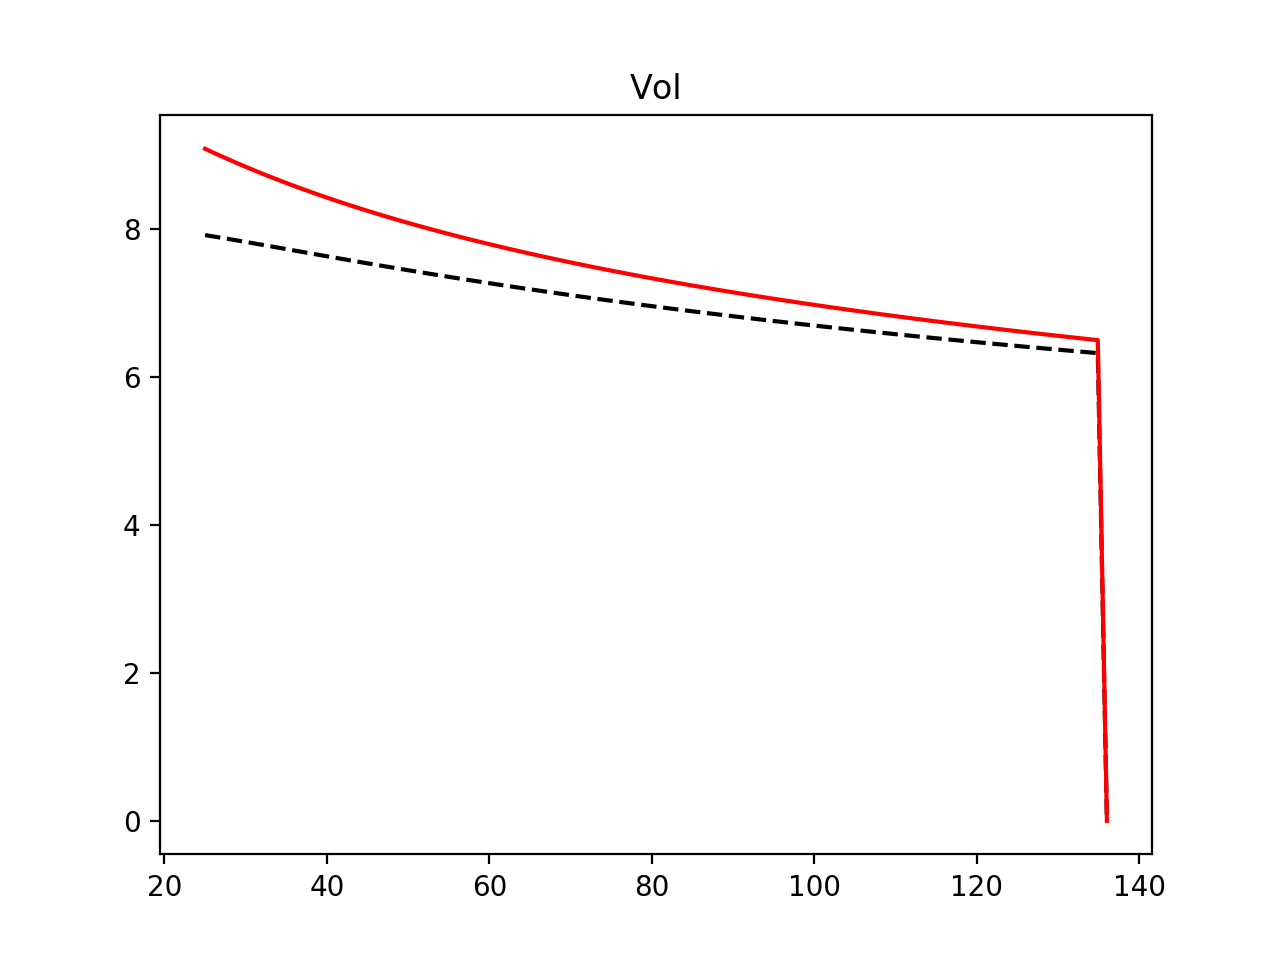

<IPython.core.display.Javascript object>


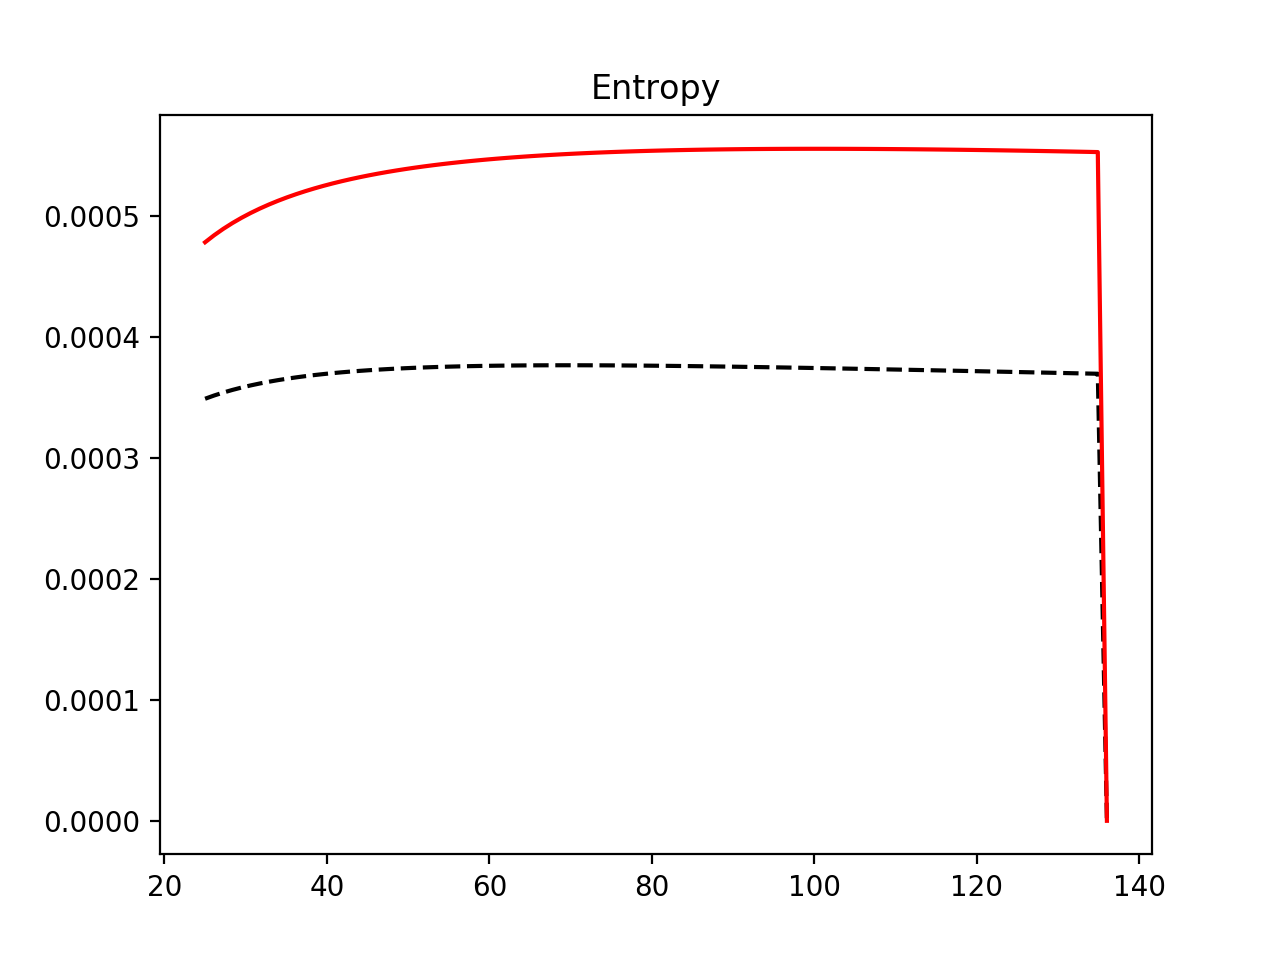

<IPython.core.display.Javascript object>


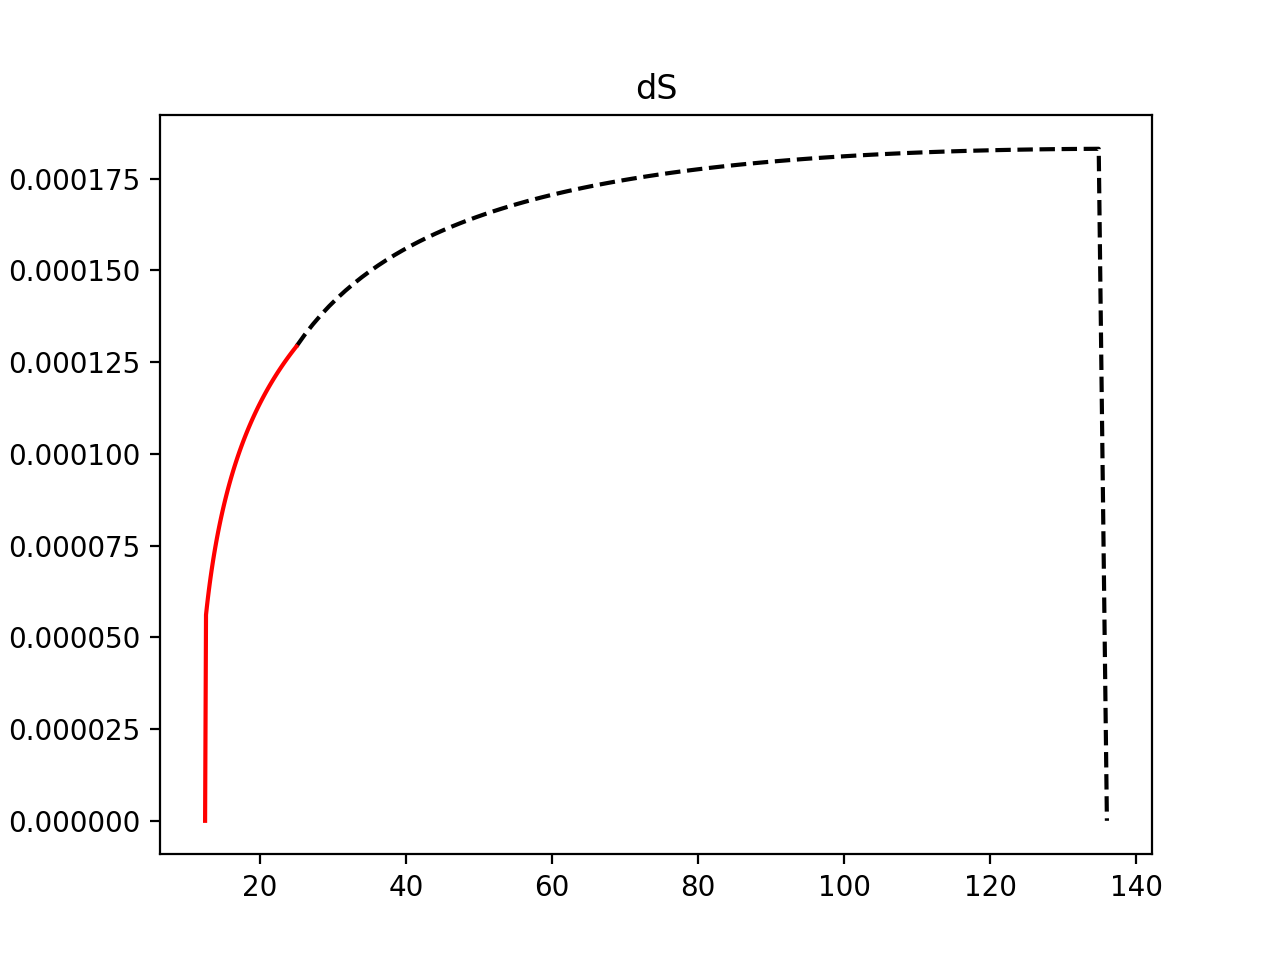

<IPython.core.display.Javascript object>


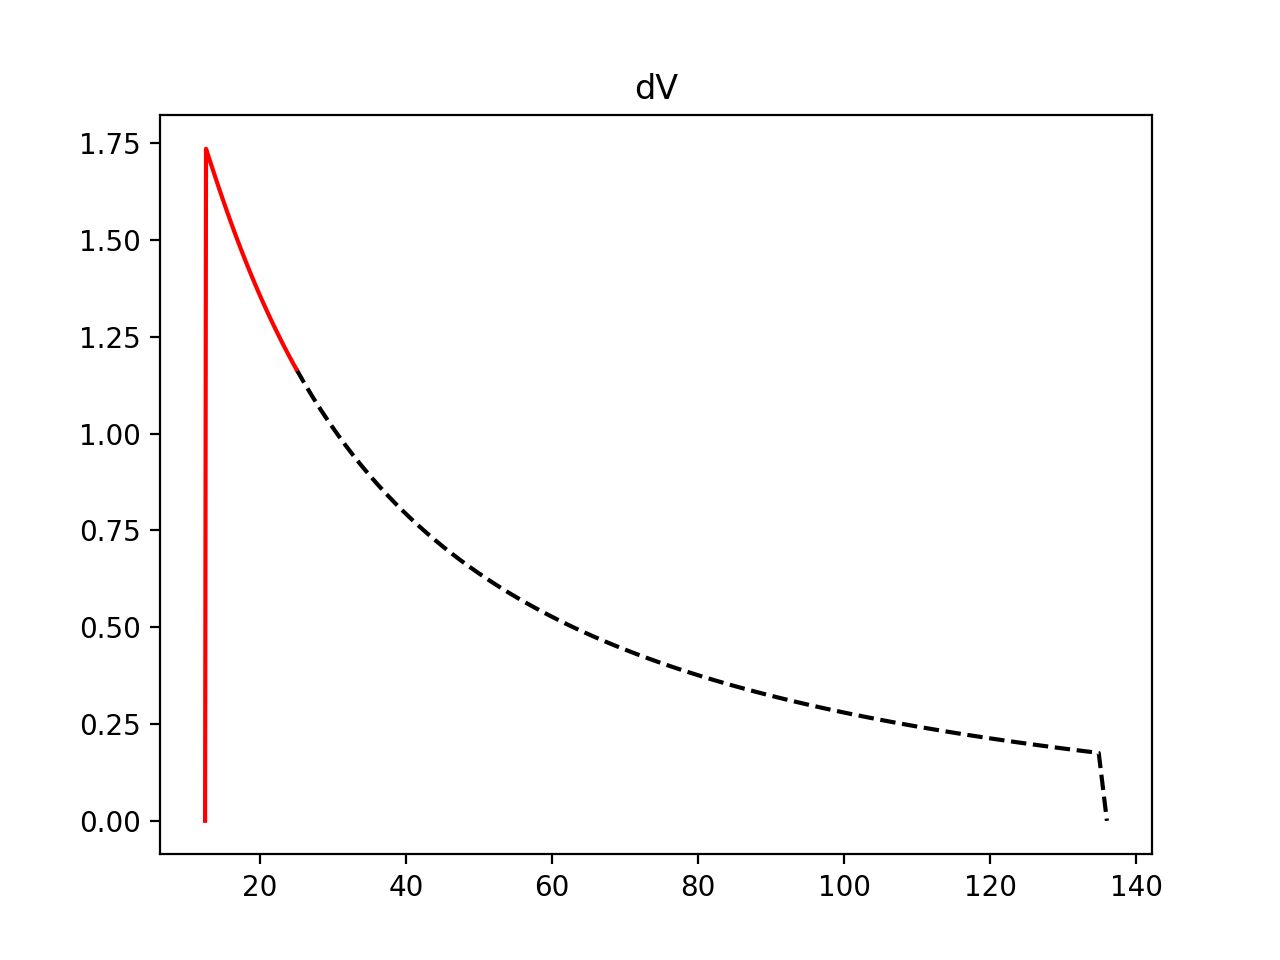

<IPython.core.display.Javascript object>


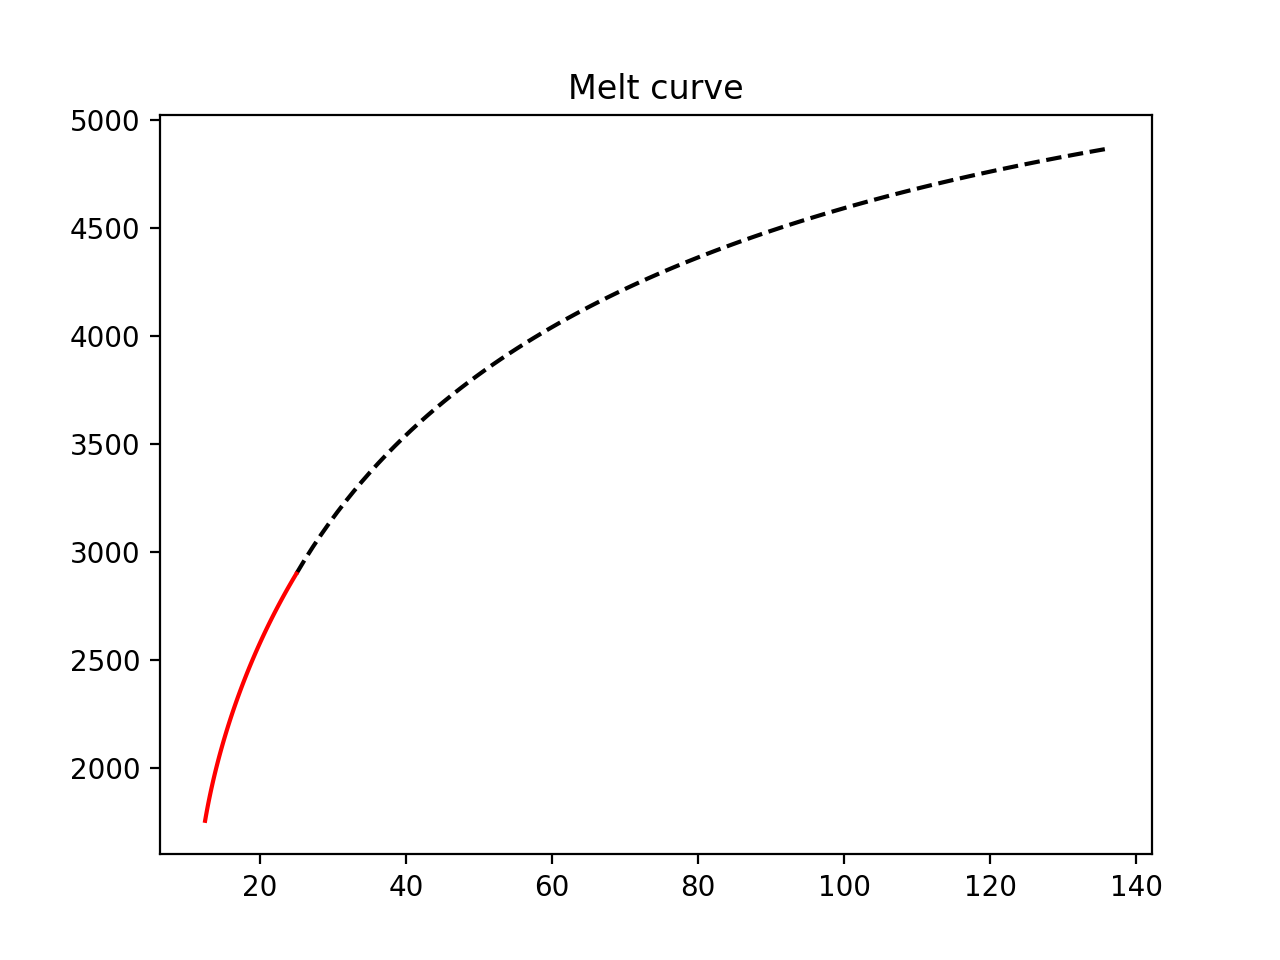

In [173]:
plt.figure()
plt.plot(P_fus_dK09, output_dK09['V1'], 'k--',
        P_fus_dK09, output_dK09['V2'], 'r-')
plt.title('Vol')

plt.figure()
plt.plot(P_fus_dK09, output_dK09['S1'], 'k--',
        P_fus_dK09, output_dK09['S2'], 'r-')
plt.title('Entropy')


plt.figure()
plt.plot(P_fus_dK09, output_dK09['dS'], 'k--',
        P_fus_hybrid, output_hybrid['dS'], 'r-')
plt.title('dS')

plt.figure()
plt.plot(P_fus_dK09, output_dK09['dV'], 'k--',
        P_fus_hybrid, output_hybrid['dV'], 'r-')
plt.title('dV')

plt.figure()
plt.plot(P_fus_dK09, T_fus_dK09, 'k--',
        P_fus_hybrid, T_fus_hybrid, 'r-')
plt.title('Melt curve')



<IPython.core.display.Javascript object>


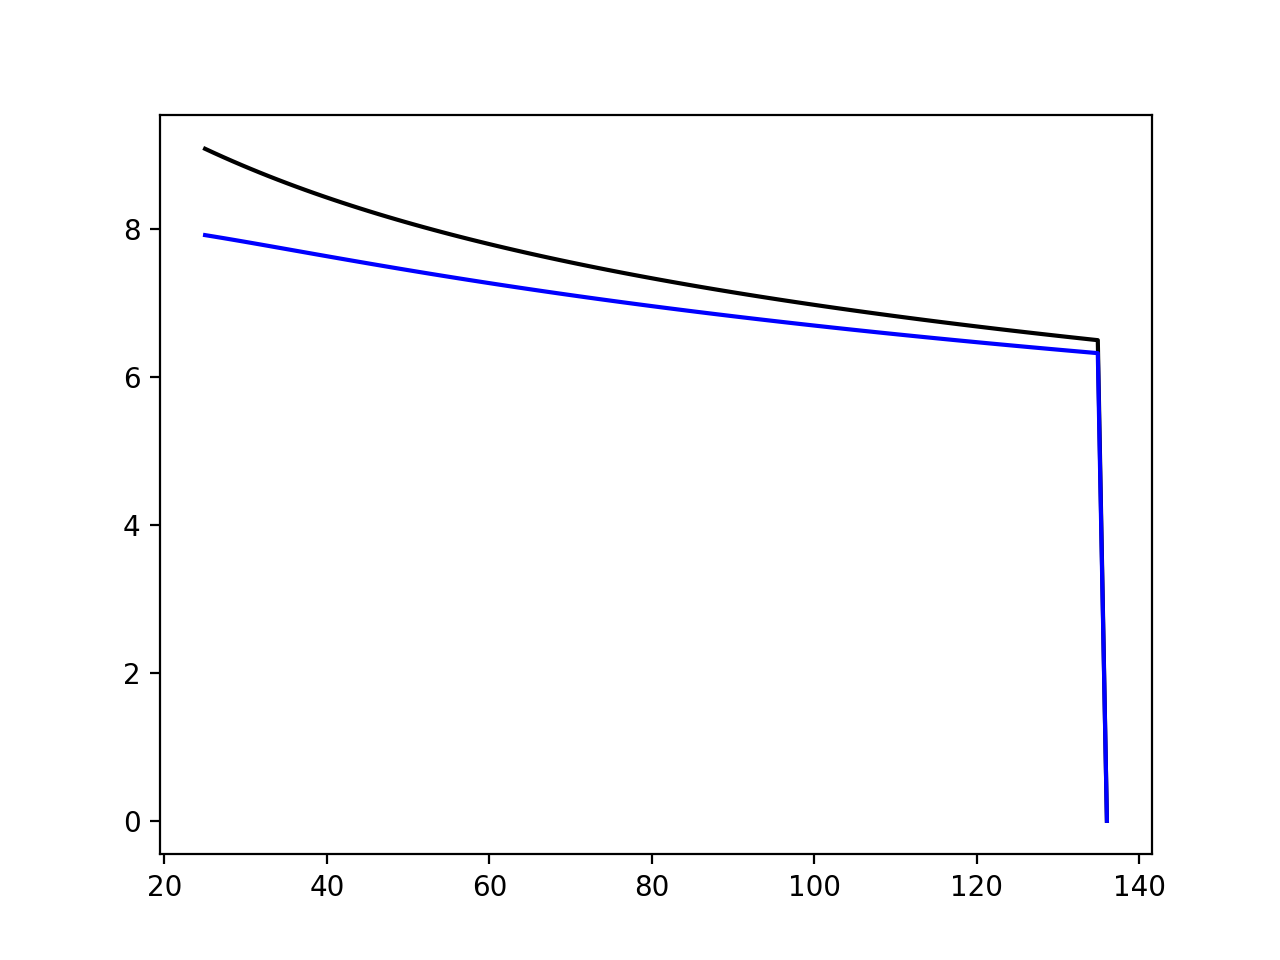

In [22]:
plt.figure()

plt.plot(P_fus_hybrid, Vliq_hybrid,'k-',P_fus_hybrid,Vsol_hybrid,'b-')

<IPython.core.display.Javascript object>


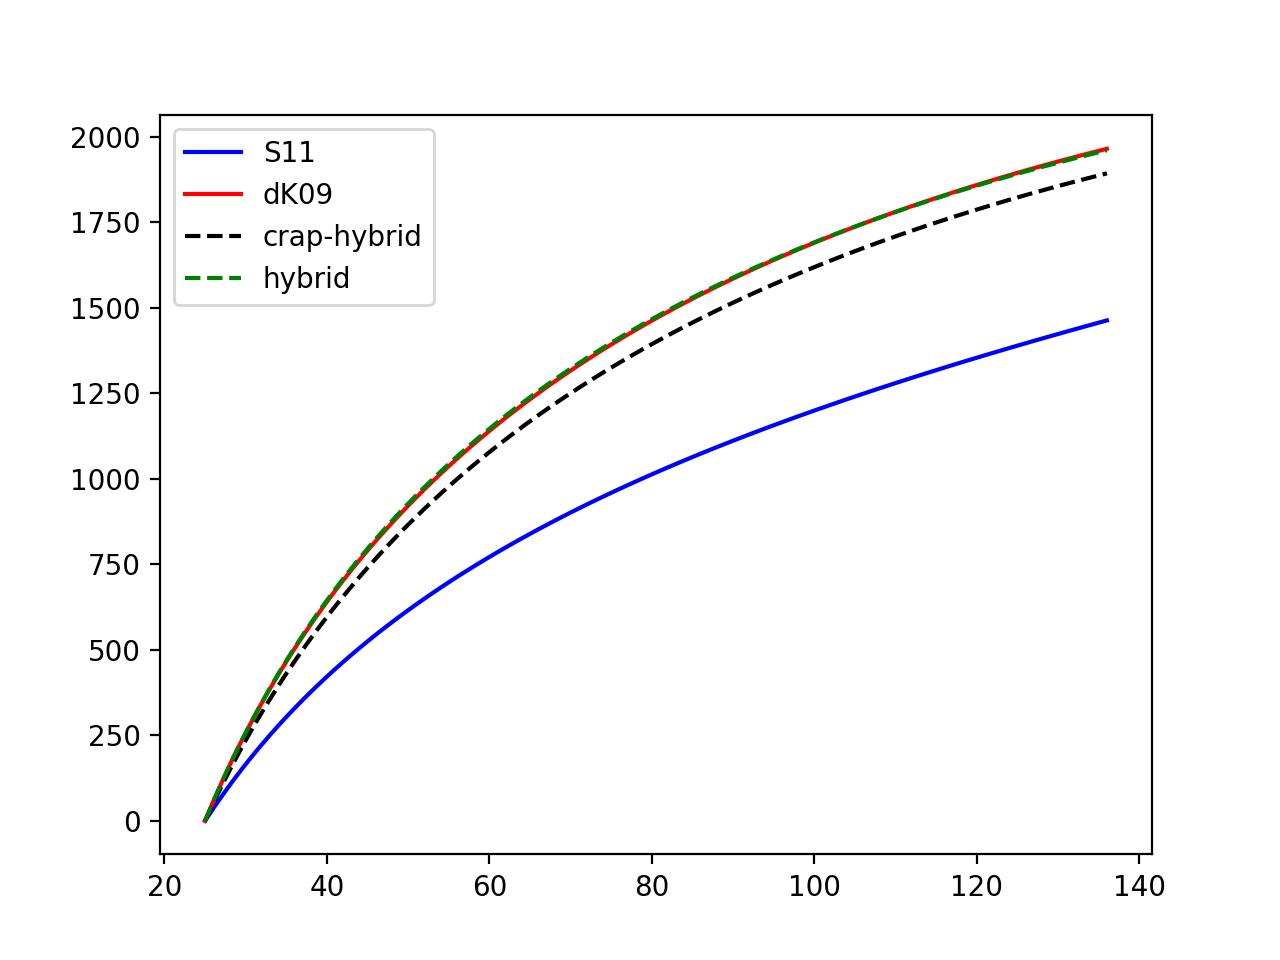

In [23]:
plt.figure()
plt.plot(P_fus, T_fus-2900, 'b-',
        P_fus_dK09, (T_fus_dK09-2900), 'r-',
        P_fus_hybrid0, T_fus_hybrid0-2900, 'k--',
        P_fus_hybrid, T_fus_hybrid-2900, 'g--')
plt.legend(['S11','dK09','crap-hybrid','hybrid'])


<IPython.core.display.Javascript object>


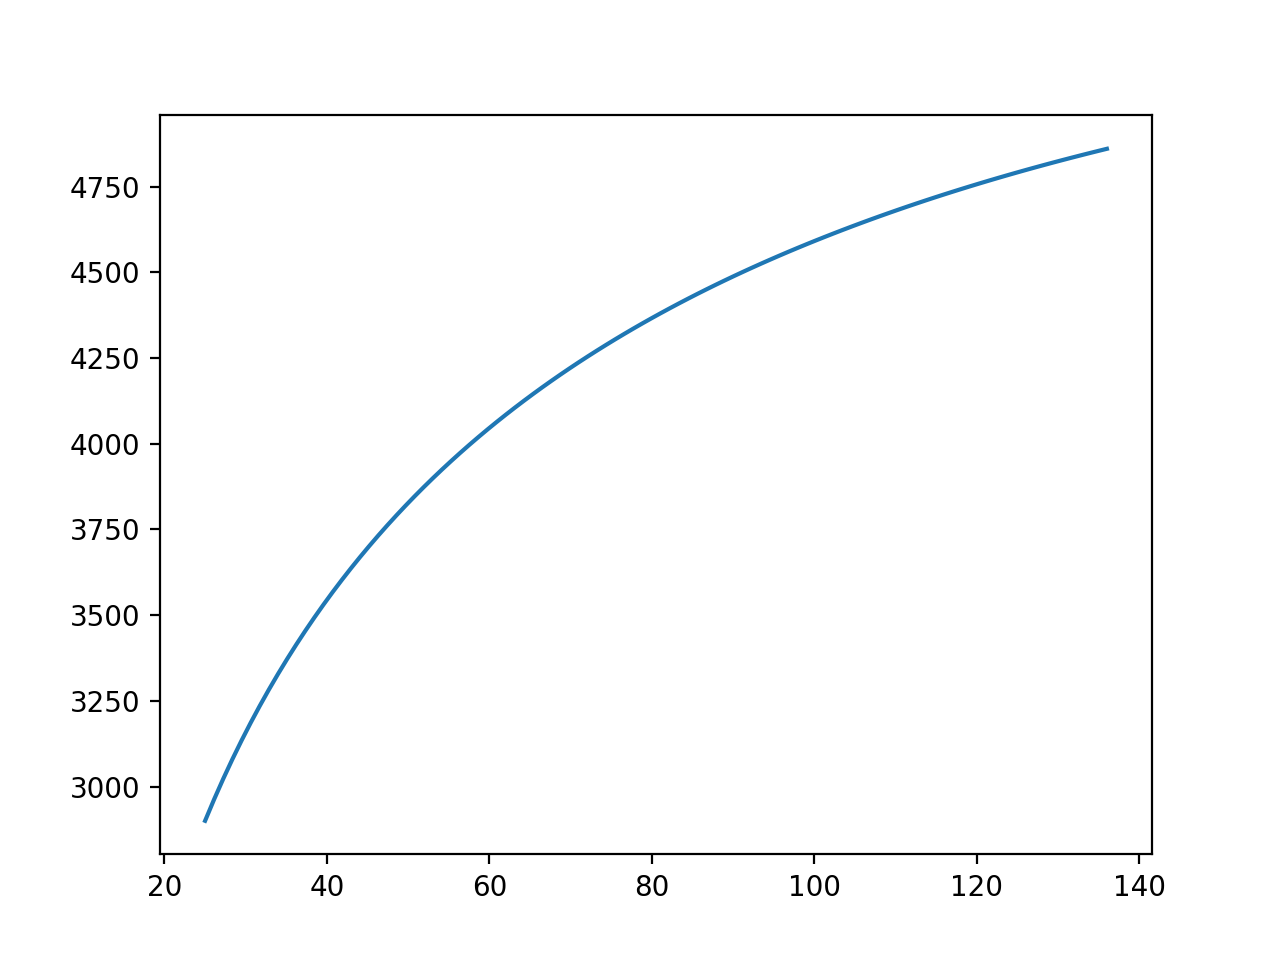

In [24]:
plt.figure()
plt.plot(P_fus_hybrid,T_fus_hybrid)

In [25]:
# V_hybrid = np.array([hybrid_volume(iP,iT)[0] for (iP,iT) in zip(P_fus_hybrid, T_fus_hybrid)])
S_liq = hybrid_entropy(Vliq_hybrid, T_fus_hybrid)
#V_sol = np.array([volume(iP,iT, mgpv_eos) for (iP,iT) in zip(P_fus_hybrid, T_fus_hybrid)])
# mgpv_eos.
S_sol = mgpv_eos.entropy(Vsol_hybrid, T_fus_hybrid)

/Users/aswolf/anaconda/envs/py36/lib/python3.6/site-packages/scipy/integrate/odepack.py:236: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
/Users/aswolf/Documents/projects/xmeos/xmeos/models/gamma.py:349: RuntimeWarning: divide by zero encountered in power
  return 1/2*(x**(-2/3)-1)
/Users/aswolf/Documents/projects/xmeos/xmeos/models/thermal.py:651: RuntimeWarning: divide by zero encountered in log
  entropy_kin = Cvlim*np.log(T_a/Tref)
/Users/aswolf/Documents/projects/xmeos/xmeos/models/thermal.py:609: RuntimeWarning: invalid value encountered in power
  dtherm_dev_a = (mexp/T0)*(T_a/T0)**(mexp-1)
/Users/aswolf/Documents/projects/xmeos/xmeos/models/thermal.py:651: RuntimeWarning: invalid value encountered in log
  entropy_kin = Cvlim*np.log(T_a/Tref)


<IPython.core.display.Javascript object>


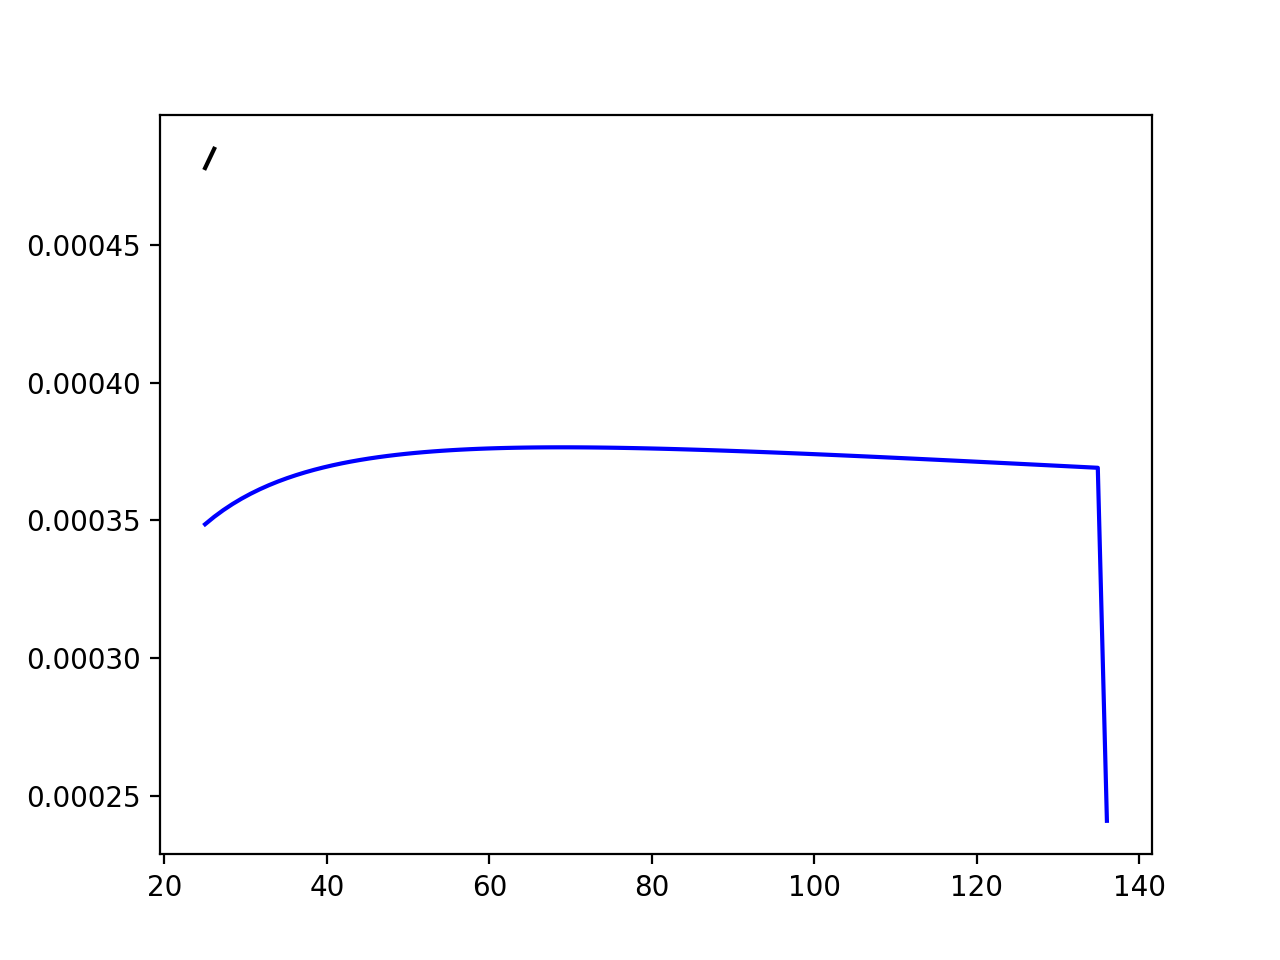

<IPython.core.display.Javascript object>


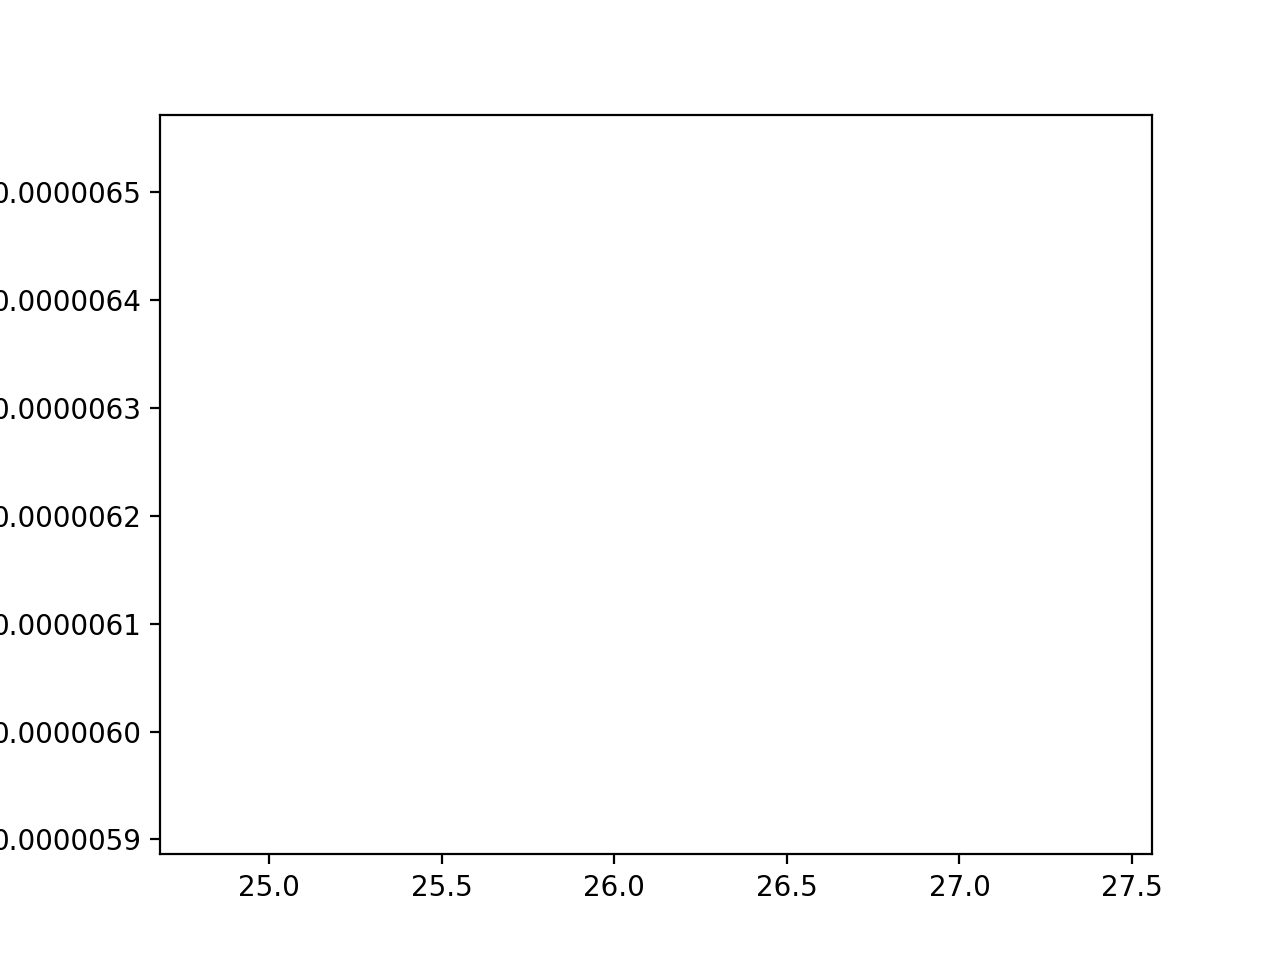

In [26]:
plt.figure()

plt.plot(P_fus_hybrid, S_liq,'k-',P_fus_hybrid,S_sol,'b-')

plt.figure()

plt.plot(P_fus_hybrid[1:], np.diff(S_liq)/np.diff(P_fus_hybrid),'b-')

In [27]:
Vmod = np.linspace(6,15,100)

T_S0 = liq_eos.ref_temp_adiabat(Vmod)
T_S0_dK09 = liq_eos_dK09.ref_temp_adiabat(Vmod)

Pmod = liq_eos_dK09.press(Vmod, T_S0)

<IPython.core.display.Javascript object>


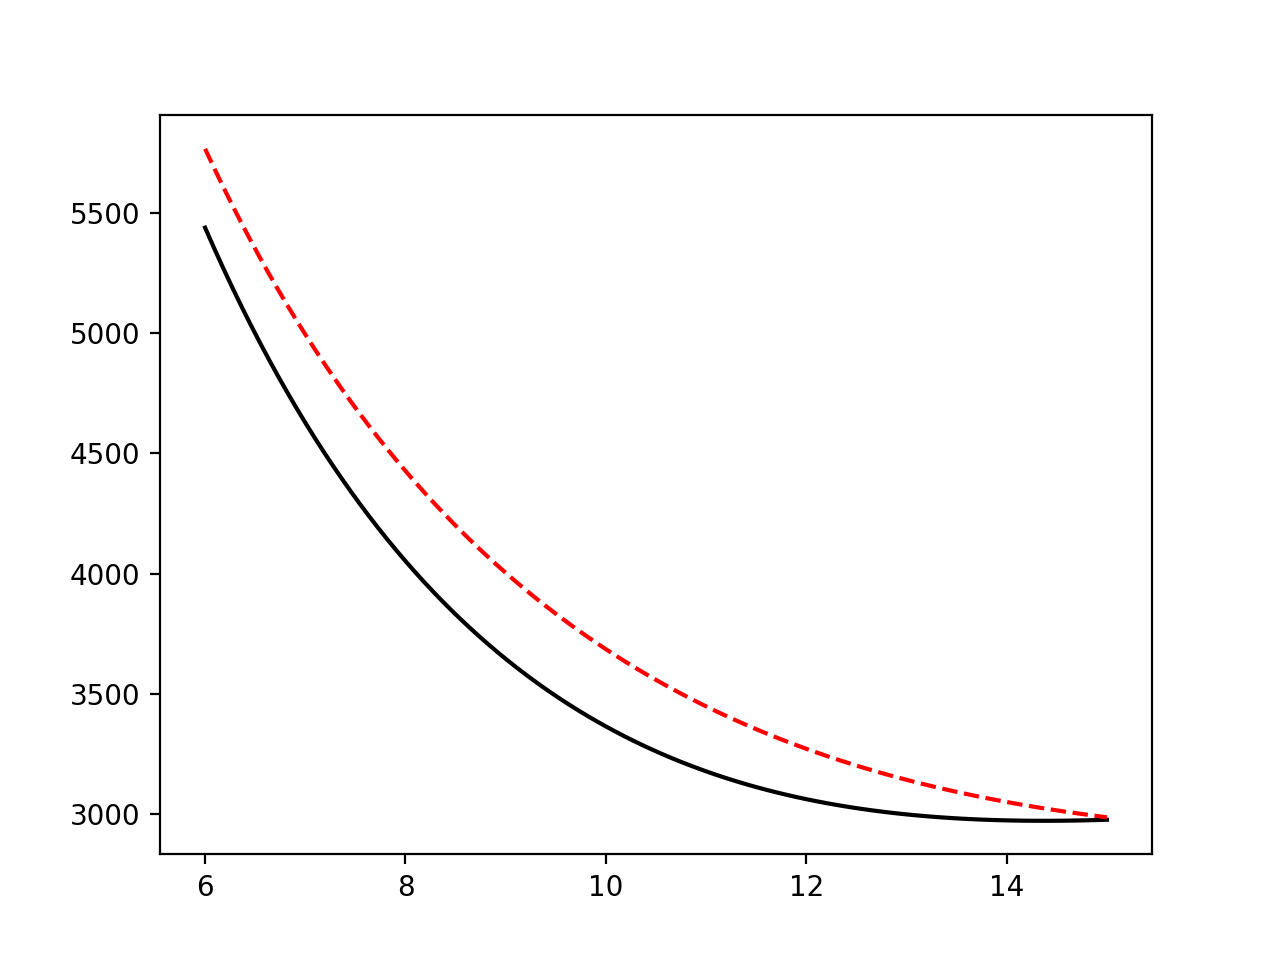

<IPython.core.display.Javascript object>


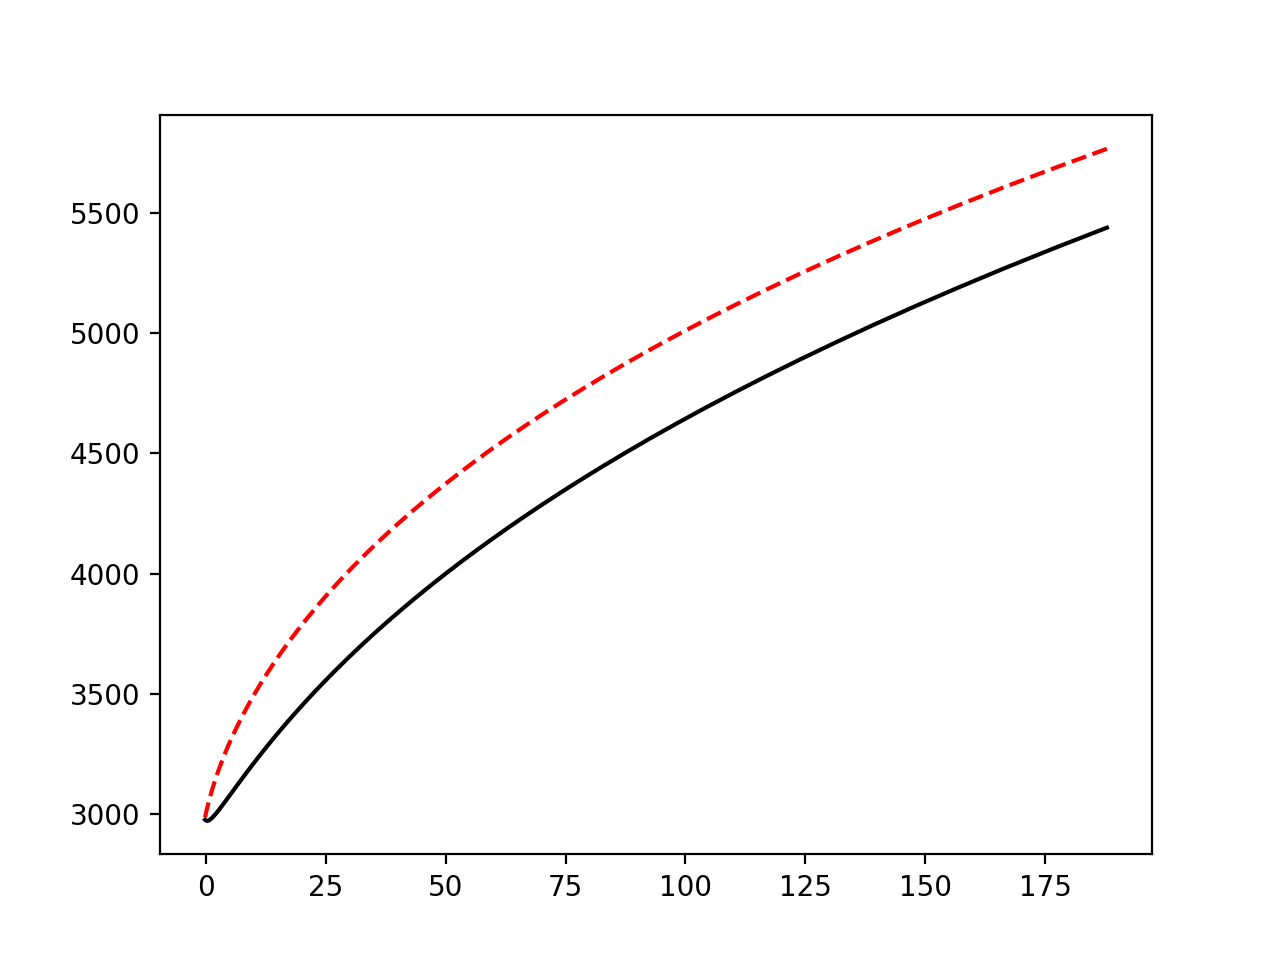

In [28]:
plt.figure()
plt.plot(Vmod, T_S0, 'k-', Vmod, T_S0_dK09,'r--')

plt.figure()
plt.plot(Pmod, T_S0, 'k-', Pmod, T_S0_dK09,'r--')


<IPython.core.display.Javascript object>


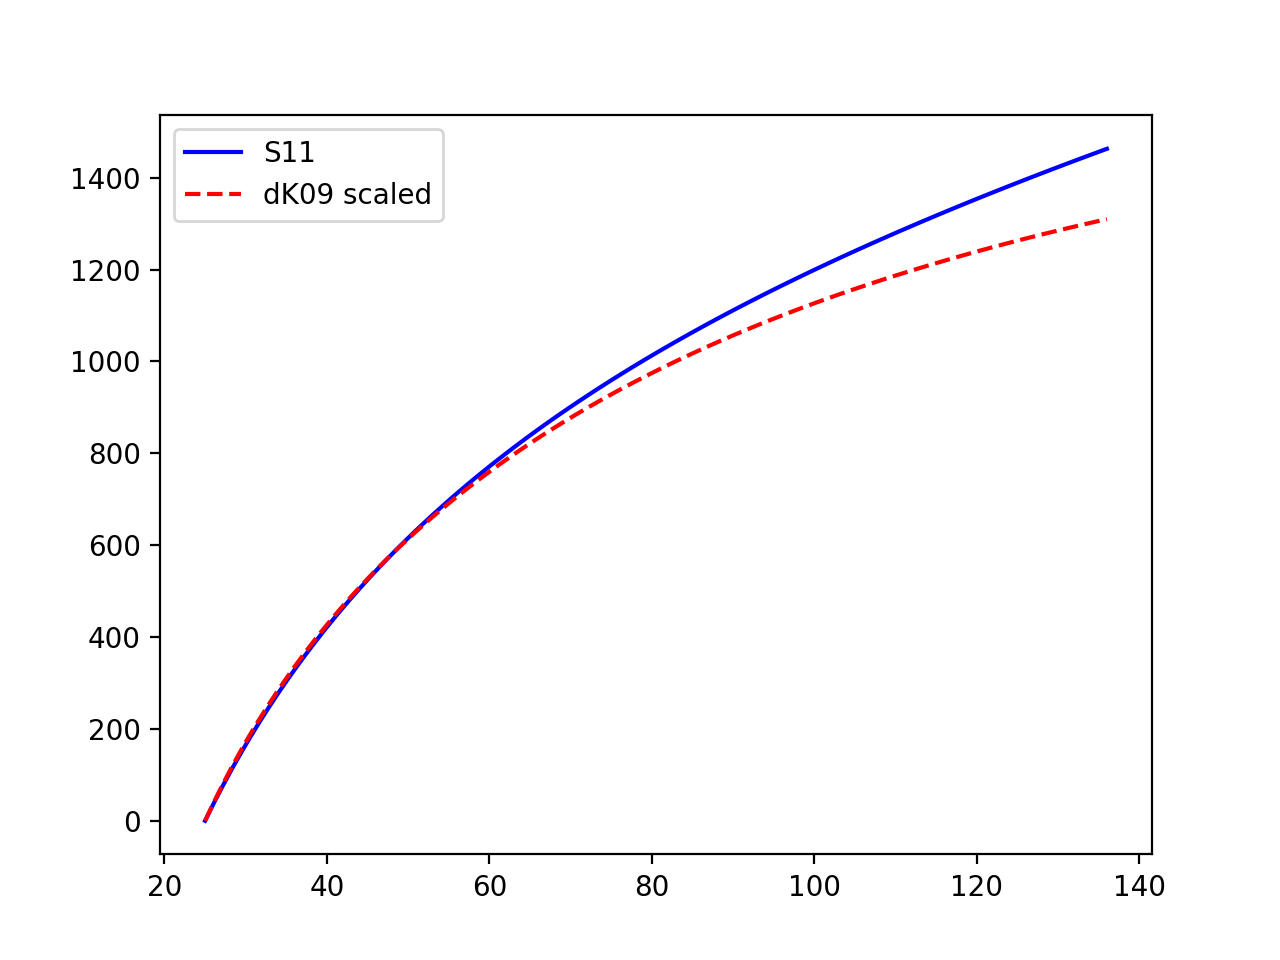

In [29]:

plt.figure()
plt.plot(P_fus, T_fus-2900, 'b-',
        P_fus_dK09, (T_fus_dK09-2900)/1.5, 'r--')
plt.legend(['S11','dK09 scaled'])
#plt.ylim(2500,5000)

# NOTE: Vinit value is off by 2% for some reason, needs addressing

In [25]:
liq_thermal_eos = liq_eos
liq_compress_eos = liq_eos_dK09

Pinit = P_fus0
Tinit = T_fus0
Vinit = liq_compress_eos.volume(Pinit, Tinit)
dV = 0.01*Vinit

dPdT = liq_compress_eos.press(Vinit, Tinit+.5)-liq_compress_eos.press(Vinit, Tinit-.5)
Cv = liq_thermal_eos.heat_capacity(Vinit, Tinit)
gamma_hybrid = Vinit*dPdT/Cv/CONSTS['PV_ratio']

gamma_compress = liq_compress_eos.gamma(Vinit, Tinit)
gamma_thermal = liq_thermal_eos.gamma(Vinit, Tinit)

dTdV = -gamma_hybrid*Tinit/Vinit
print(dTdV)
dT = -dTdV*dV
T = Tinit+dT
print(T)
print(gamma_compress, gamma_thermal, gamma_hybrid)

[-51.74768487]
[2907.72629255]
[0.26284985] [-0.07337817] [0.26642388]


/Users/aswolf/Documents/projects/xmeos/xmeos/models/compress.py:420: RuntimeWarning: invalid value encountered in power
  x_a = vratio_a**(1/3)
/Users/aswolf/Documents/projects/xmeos/xmeos/models/gamma.py:349: RuntimeWarning: invalid value encountered in power
  return 1/2*(x**(-2/3)-1)


In [ ]:
def trace_hybrid_adiabat(Pinit, Tinit, Plim, liq_thermal_eos, liq_compress_eos,
                         Vinit=None, N=100):
    
    Pad = np.zeros(N)
    Tad = np.zeros(N)
    gamma = np.zeroes(N)
    Tad[0] = Tinit
    Pad[0] = Pinit
    
    Vinit = volume(Pinit, Tinit, liq_compress_eos, Vinit=Vinit)
    dV = 0.01*Vinit

    for ind, (P, T) in enumerate(zip(Pbound[:-1], Tbound[:-1])):
        Pinit = liq_compress_eos.
        dPdT = (liq_compress_eos.press(Vinit, Tinit+.5)
                - liq_compress_eos.press(Vinit, Tinit-.5))
        Cv = liq_thermal_eos.heat_capacity(Vinit, Tinit)
        gamma_hybrid = Vinit*dPdT/Cv/CONSTS['PV_ratio']
        
        dTdV = -gamma_hybrid*Tinit/Vinit

        dT = -dTdV*dV
        
        
        gamma[ind] = gamma_hybrid
        Tad[ind+1] = Tinit+dT
        Pad[ind]
        
        
        
        Vsol = volume(P, T, sol_eos, Vinit=Vsol_init)
        Vliq = volume(P, T, liq_compress_eos, Vinit=Vliq_init)
        
        dV = Vliq-Vsol
        dS = (liq_thermal_eos.entropy(Vliq, T) 
              - sol_eos.entropy(Vsol, T))[0]
        
        dTdP = dV/dS/CONSTS['PV_ratio']
        dT = dTdP*dP
        
        Pbound[ind+1] = P+dP
        Tbound[ind+1] = T+dT
        
        Vsol_init = Vsol
        Vliq_init = Vliq

    return Pbound, Tbound

In [40]:
liq_eos.heat_capacity(Vmod,T_S0)

array([0.00031199, 0.00031217, 0.00031231, 0.00031242, 0.00031249,
       0.00031254, 0.00031256, 0.00031255, 0.00031251, 0.00031245,
       0.00031237, 0.00031227, 0.00031215, 0.00031201, 0.00031185,
       0.00031169, 0.00031151, 0.00031132, 0.00031112, 0.00031092,
       0.00031071, 0.0003105 , 0.00031028, 0.00031007, 0.00030985,
       0.00030964, 0.00030943, 0.00030923, 0.00030904, 0.00030885,
       0.00030867, 0.0003085 , 0.00030835, 0.00030821, 0.00030808,
       0.00030797, 0.00030788, 0.00030781, 0.00030775, 0.00030772,
       0.0003077 , 0.00030771, 0.00030774, 0.0003078 , 0.00030788,
       0.00030798, 0.00030812, 0.00030827, 0.00030846, 0.00030867,
       0.00030891, 0.00030918, 0.00030948, 0.00030981, 0.00031017,
       0.00031056, 0.00031098, 0.00031142, 0.0003119 , 0.00031241,
       0.00031294, 0.00031351, 0.00031411, 0.00031473, 0.00031538,
       0.00031607, 0.00031678, 0.00031751, 0.00031828, 0.00031907,
       0.00031988, 0.00032072, 0.00032158, 0.00032247, 0.00032

In [45]:
(liq_eos.internal_energy(Vmod,T_S0+.5)-liq_eos.internal_energy(Vmod,T_S0-.5))/liq_eos.heat_capacity(Vmod,T_S0)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])